In [133]:
#pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [51]:
# Import temporal modules needed for testing plotting
import matplotlib.pyplot as plt
import numpy as np
import os 
from datetime import datetime
import seaborn as sns


%matplotlib inline


In [4]:
# Extract results arrays

# Define the path to the parent directory
parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/51-82_reverse_pm_for_distortion_experiment'
#parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output'
#parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/51-82_masked_output_experiment'
#parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/52-82_orbit_2022-2023_batch_output_combined_dist'


data_folder_name = 'output_data'

In [5]:
save_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/51-82_reverse_pm_for_distortion_experiment/analysis_plots'
def save_plot(save_dir, name):
    save_path = os.path.join(save_dir, f"{name}.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    


## 0. Functions

In [6]:
def export_pm_output_data(parent_dir, vars_folder_name, file_name, variable_names):
    """
    Extracts pattern matching output variables from .npz files in subdirectories of a parent directory.
    
    Args:
    parent_dir (str): The path to the parent directory containing subdirectories.
    vars_folder_name (str): The name of the folder within each subdirectory that contains the .npz file.
    **kwargs: Keyword arguments specifying the variable names to extract from the .npz files.
    
    The possible key variables to extract and their descriptions are:
    - upm: Eastward ice drift displacement in destination SRS units.
    - vpm: Northward ice drift displacement in destination SRS units.
    - apm: Angle that gives the highest MCC (Maximum Cross Correlation).
    - rpm: Maximum cross correlation (MCC) value.
    - hpm: Hessian of the cross-correlation at the MCC point.
    - ssim: Similarity index between the two images for each point.
    - lon2pm: Longitude of results on image 2.
    - lat2pm: Latitude of results on image 2.
    - gpi1: Mask of good pixels after filtering with the hessian.
    - gpi2: Mask of good pixels after filtering with the hessian and number of neighboring pixels.
    - model_u - Eastward model ice drift displacement in destination SRS units.
    - model_v - Northward model ice drift displacement in destination SRS units.
    
    Returns:
    dict: A dictionary containing lists of extracted data for each specified variable.
    list: A list of timestamps extracted from the folder names.
    """
    
    # Initialize a dictionary to hold lists for each variable
    data_dict = {var: [] for var in variable_names}
    timestamps = []

    # Iterate through subdirectories (folders for each pair)
    for subdir in os.listdir(parent_dir):
        sub_dir_path = os.path.join(parent_dir, subdir)

        # Check if the .npz file exists
        npz_file_path = os.path.join(sub_dir_path, vars_folder_name, f'{file_name}.npz')
        if os.path.exists(npz_file_path):
            # Load the contents of the .npz file
            npz_data = np.load(npz_file_path)
            

            # Extract and append parameters to their respective lists in the dictionary
            for var in variable_names:
                if var in npz_data:
                    data_dict[var].append(npz_data[var])

            # Extract and append the timestamps from folder names
            timestamps.append(subdir)

    # Return the dictionary and the timestamps
    return data_dict, timestamps


def calculate_mean_distor_parameters(timestamps, rpm_list, hpm_list, ssim_list, gpi_list=None):
    """
    Calculates the mean, minimum, and maximum values for various distortion parameters 
    for each timestamp and optionally filters the data based on a good pixel index list.

    Parameters:
    timestamps (list): List of timestamps corresponding to each set of data.
    rpm_list (list): List of RPM (Maximum Cross Correlation) values for each timestamp.
    hpm_list (list): List of HPM (Hessian of Cross-Correlation at MCC point) values for each timestamp.
    ssim_list (list): List of SSIM (Similarity Index) values for each timestamp.
    gpi (list, optional): List of good pixel index masks to filter the data. 
                               If None, no filtering is applied.

    Returns:
    dict: A dictionary containing the following keys and their corresponding list of values:
        - 'rpm_mean': Mean values of RPM.
        - 'rpm_min': Minimum values of RPM.
        - 'rpm_max': Maximum values of RPM.
        - 'hpm_mean': Mean values of HPM.
        - 'hpm_min': Minimum values of HPM.
        - 'hpm_max': Maximum values of HPM.
        - 'ssim_mean': Mean values of SSIM.
        - 'ssim_min': Minimum values of SSIM.
        - 'ssim_max': Maximum values of SSIM.
    
    Each key in the dictionary corresponds to a specific statistic (mean, min, max) for each parameter (RPM, HPM, SSIM).
    """
    
    # Initialize a dictionary to store statistics for each parameter
    statistics = {
        'rpm_mean': [], 'rpm_min': [], 'rpm_max': [],
        'hpm_mean': [], 'hpm_min': [], 'hpm_max': [],
        'ssim_mean': [], 'ssim_min': [], 'ssim_max': []
    }
    
    true_count_list = [] 
    # Iterate through the pairs and calculate statistics
    for i in range(len(timestamps)):
        # Calculate number of good pixelas for further normalization
        true_count = np.count_nonzero(gpi2_list[i])
        true_count_list.append(true_count)
        
        # Determine data based on whether gpi_list is defined
        rpm_data = rpm_list[i] if gpi_list is None else rpm_list[i][gpi_list[i]]
        hpm_data = hpm_list[i] if gpi_list is None else hpm_list[i][gpi_list[i]]
        ssim_data = ssim_list[i] if gpi_list is None else ssim_list[i][gpi_list[i]]

        # Calculate and append statistics for RPM, HPM, and SSIM
        for param, data in zip(['rpm', 'hpm', 'ssim'], [rpm_data, hpm_data, ssim_data]):
            mean = round(np.nanmean(data), 2)
            min_val = round(np.nanmin(data), 2)
            max_val = round(np.nanmax(data), 2)
            
            statistics[f'{param}_mean'].append(mean)
            statistics[f'{param}_min'].append(min_val)
            statistics[f'{param}_max'].append(max_val)

        # Print the calculated statistics for the current pair
        print(f"Pair {i + 1}:")
        print(f"RPM Mean: {statistics['rpm_mean'][-1]}, Min: {statistics['rpm_min'][-1]}, Max: {statistics['rpm_max'][-1]}")
        print(f"HPM Mean: {statistics['hpm_mean'][-1]}, Min: {statistics['hpm_min'][-1]}, Max: {statistics['hpm_max'][-1]}")
        print(f"SSIM Mean: {statistics['ssim_mean'][-1]}, Min: {statistics['ssim_min'][-1]}, Max: {statistics['ssim_max'][-1]}")
        print(f"True gpi: {true_count_list[-1]}")
        print("-" * 20)

    return statistics, true_count_list


def calculate_mean_distor_parameters_with_hes(timestamps, rpm_list, hpm_list, ssim_list, hessian=8):
    """
    Calculates the mean, minimum, and maximum values for various distortion parameters 
    for each timestamp and optionally filters the data based on a good pixel index list.

    Parameters:
    timestamps (list): List of timestamps corresponding to each set of data.
    rpm_list (list): List of RPM (Maximum Cross Correlation) values for each timestamp.
    hpm_list (list): List of HPM (Hessian of Cross-Correlation at MCC point) values for each timestamp.
    ssim_list (list): List of SSIM (Similarity Index) values for each timestamp.
    gpi (list, optional): List of good pixel index masks to filter the data. 
                               If None, no filtering is applied.

    Returns:
    dict: A dictionary containing the following keys and their corresponding list of values:
        - 'rpm_mean': Mean values of RPM.
        - 'rpm_min': Minimum values of RPM.
        - 'rpm_max': Maximum values of RPM.
        - 'hpm_mean': Mean values of HPM.
        - 'hpm_min': Minimum values of HPM.
        - 'hpm_max': Maximum values of HPM.
        - 'ssim_mean': Mean values of SSIM.
        - 'ssim_min': Minimum values of SSIM.
        - 'ssim_max': Maximum values of SSIM.
    
    Each key in the dictionary corresponds to a specific statistic (mean, min, max) for each parameter (RPM, HPM, SSIM).
    """
    
    # Initialize a dictionary to store statistics for each parameter
    statistics = {
        'rpm_mean': [], 'rpm_min': [], 'rpm_max': [],
        'hpm_mean': [], 'hpm_min': [], 'hpm_max': [],
        'ssim_mean': [], 'ssim_min': [], 'ssim_max': []
    }
    
    gpi_list = []
    true_count_list = [] 

    # Iterate through the pairs and calculate statistics
    for i in range(len(timestamps)):
        gpi = (hpm_list[i]>hessian)
        
        # Calculate number of good pixelas for further normalization
        true_count = np.count_nonzero(gpi)
        true_count_list.append(true_count)
        gpi_list.append(gpi)
        
        # Determine data based on whether gpi_list is defined
        rpm_data = rpm_list[i][gpi]
        hpm_data = hpm_list[i][gpi]
        ssim_data = ssim_list[i][gpi]
        
        # Calculate and append statistics for RPM, HPM, and SSIM
        for param, data in zip(['rpm', 'hpm', 'ssim'], [rpm_data, hpm_data, ssim_data]):
            mean = round(np.nanmean(data), 2)
            min_val = round(np.nanmin(data), 2)
            max_val = round(np.nanmax(data), 2)
            
            statistics[f'{param}_mean'].append(mean)
            statistics[f'{param}_min'].append(min_val)
            statistics[f'{param}_max'].append(max_val)

        # Print the calculated statistics for the current pair
        print(f"Pair {i + 1}:")
        print(f"RPM Mean: {statistics['rpm_mean'][-1]}, Min: {statistics['rpm_min'][-1]}, Max: {statistics['rpm_max'][-1]}")
        print(f"HPM Mean: {statistics['hpm_mean'][-1]}, Min: {statistics['hpm_min'][-1]}, Max: {statistics['hpm_max'][-1]}")
        print(f"SSIM Mean: {statistics['ssim_mean'][-1]}, Min: {statistics['ssim_min'][-1]}, Max: {statistics['ssim_max'][-1]}")
        print(f"True gpi: {true_count_list[-1]}")
        print("-" * 20)

    return statistics, gpi_list, true_count_list



## 1. Importing data

In [7]:
# Defining domain importing X and Y for subset (it's mutual for all pairs)
import sys
sys.path.append("./modules")

from nansat import Nansat, Domain, NSR
from config import proj4, srs


npz_file_path = os.path.join(parent_dir,  "domain_output.npz")
npz_data = np.load(npz_file_path)

    
X = npz_data['X']
Y = npz_data['Y']

mod_res = 2500
mod_dom = Domain(srs, f'-te {min(X.data)} {min(Y.data) - mod_res * 2} {max(X.data) + mod_res} {max(Y.data)} -tr {mod_res} {mod_res}')
lon1pm, lat1pm = mod_dom.get_geolocation_grids()
x, y = mod_dom.get_geolocation_grids(dst_srs=srs)
dst_res = 100
dst_dom = Domain(srs, f'-te {min(X.data)} {min(Y.data) - dst_res * 2} {max(X.data) + dst_res} {max(Y.data)} -tr {dst_res} {dst_res}')
x100, y100 = dst_dom.get_geolocation_grids(dst_srs=srs)

In [8]:
# Importing drift parametrs (between SAR1 and SAR2)
data_folder_name = 'output_data' # new way
#data_folder_name = 'sar_drift_output' #old way
file_name = 'sar_drift_output'
drift_variable_names = ['upm', 'vpm', 'rpm', 'hpm', 'ssim', 'gpi2' ]
sar_drift_data, timestamps = export_pm_output_data(parent_dir, data_folder_name, file_name, drift_variable_names)


u_sar_list = sar_drift_data['upm']
v_sar_list = sar_drift_data['vpm']
sar12_rpm_list = sar_drift_data['rpm']
sar12_hpm_list = sar_drift_data['hpm']  
sar12_ssim_list = sar_drift_data['ssim']
gpi2_list = sar_drift_data['gpi2']


# Replace inf with NaN before calculating the mean
u_sar_list = np.where(np.isinf(u_sar_list), np.nan, u_sar_list)
v_sar_list = np.where(np.isinf(v_sar_list), np.nan, v_sar_list)


len(timestamps)

18

In [13]:
#parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/51-82_masked_output_experiment'
data_folder_name = 'output_data'
file_name = 'warped_hpm' #'warped_masks'
distor_variable_names = ['warped_hpm'] # ['sar_warped_mask']
mod_distor_data, timestamps = export_pm_output_data(parent_dir, data_folder_name, file_name, distor_variable_names)
    
sar_warped_mask_list = mod_distor_data['warped_hpm'] #['sar_warped_mask']
len(sar_warped_mask_list)

18

In [14]:
# Importing model drift parametrs (between SAR1 and SAR2)
data_folder_name = 'output_data' # new way
#data_folder_name = 'mod_drift_output' #old way
file_name = 'mod_drift_output'
mod_drift_variable_names = ['model_u', 'model_v' ]
mod_drift_data, timestamps = export_pm_output_data(parent_dir, data_folder_name, file_name, mod_drift_variable_names)


u_b_list = mod_drift_data['model_u']
v_b_list = mod_drift_data['model_v']
len(timestamps)

18

In [16]:
# Importing distortion parametrs (between SAR2 real and SAR2 prediction with sar drift)
#parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/52-82_orbit_2022-2023_batch_output_combined_dist'
#data_folder_name = 'sar_distort_error_data' #old way
file_name = 'sar_warped_arrays'
distor_variable_names = ['sar_warped_hv']
sar_distor_data, timestamps = export_pm_output_data(parent_dir,data_folder_name, file_name, distor_variable_names)
    
sar_warped_hv = sar_distor_data['sar_warped_hv']
len(sar_warped_hv)

18

In [21]:
# Importing distortion parametrs (between SAR2 real and SAR2 prediction with sar drift)
#parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/52-82_orbit_2022-2023_batch_output_combined_dist'
#data_folder_name = 'sar_distort_error_data' #old way
file_name = 'sar_distort_error_data_50_12' # 'sar_distort_plots_400_50'
distor_variable_names = ['rpm', 'hpm', 'ssim', 'gpi2']
sar_distor_data, timestamps = export_pm_output_data(parent_dir,data_folder_name, file_name, distor_variable_names)
    
sar_rpm_list_50_12 = sar_distor_data['rpm']
sar_hpm_list_50_12 = sar_distor_data['hpm']
sar_ssim_list_50_12 = sar_distor_data['ssim']
gpi_sar_warp_50_12 = sar_drift_data['gpi2']
len(sar_ssim_list_50_12)

18

In [19]:
# Importing distortion parametrs (between SAR2 real and SAR2 prediction with sar drift)
#parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/52-82_orbit_2022-2023_batch_output_combined_dist'
#data_folder_name = 'sar_distort_error_data' #old way
file_name = 'sar_distort_error_data_400_50'
distor_variable_names = ['rpm', 'hpm', 'ssim', 'gpi2']
sar_distor_data, timestamps = export_pm_output_data(parent_dir,data_folder_name, file_name, distor_variable_names)
    
sar_rpm_list_400_50 = sar_distor_data['rpm']
sar_hpm_list_400_50 = sar_distor_data['hpm']
sar_ssim_list_400_50 = sar_distor_data['ssim']
gpi_sar_warp_400_50 = sar_drift_data['gpi2']
len(sar_ssim_list_400_50)

18

In [46]:
sar_distor_statistics, sar_gpi, sar_true_count = calculate_mean_distor_parameters_with_hes(timestamps, sar_rpm_list_400_50, sar_hpm_list_400_50, sar_ssim_list_400_50, hessian=8)
sar_rpm_mean = sar_distor_statistics['rpm_mean']

sar_rpm_min = sar_distor_statistics['rpm_min']
sar_rpm_max = sar_distor_statistics['rpm_max']
sar_hpm_mean = sar_distor_statistics['hpm_mean']
sar_hpm_min = sar_distor_statistics['hpm_min']
sar_hpm_max = sar_distor_statistics['hpm_max']
sar_ssim_mean = sar_distor_statistics['ssim_mean']
sar_ssim_min = sar_distor_statistics['ssim_min']
sar_ssim_max = sar_distor_statistics['ssim_max']


Pair 1:
RPM Mean: 0.47, Min: 0.05, Max: 0.91
HPM Mean: 19.61, Min: 8.0, Max: 571.45
SSIM Mean: 0.35, Min: 0.0, Max: 0.94
True gpi: 6651
--------------------
Pair 2:
RPM Mean: 0.45, Min: 0.05, Max: 0.96
HPM Mean: 18.7, Min: 8.0, Max: 534.0
SSIM Mean: 0.34, Min: 0.0, Max: 0.85
True gpi: 6009
--------------------
Pair 3:
RPM Mean: 0.54, Min: 0.04, Max: 1.0
HPM Mean: 20.02, Min: 8.0, Max: 534.0
SSIM Mean: 0.41, Min: 0.0, Max: 0.86
True gpi: 9524
--------------------
Pair 4:
RPM Mean: 0.52, Min: 0.03, Max: 0.94
HPM Mean: 19.38, Min: 8.0, Max: 534.0
SSIM Mean: 0.38, Min: -0.0, Max: 0.89
True gpi: 9256
--------------------
Pair 5:
RPM Mean: 0.42, Min: 0.02, Max: 0.87
HPM Mean: 19.26, Min: 8.01, Max: 479.65
SSIM Mean: 0.28, Min: -0.01, Max: 0.93
True gpi: 2964
--------------------
Pair 6:
RPM Mean: 0.56, Min: 0.01, Max: 0.92
HPM Mean: 19.1, Min: 8.0, Max: 534.0
SSIM Mean: 0.39, Min: 0.0, Max: 0.87
True gpi: 7517
--------------------
Pair 7:
RPM Mean: 0.51, Min: 0.04, Max: 0.92
HPM Mean: 19.25,

In [22]:
print(timestamps)
date_labels = []
for ts in timestamps:
    # Split the string into the start and end dates
    start_date_str, end_date_str = ts.split('_')
    # Convert to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y%m%dT%H%M%S")
    end_date = datetime.strptime(end_date_str, "%Y%m%dT%H%M%S")
    # Format the dates as "DD-DD.MM.YYYY"
    date_label = f"{start_date.day:02d}-{end_date.day:02d}.{start_date.month:02d}.{start_date.year}"
    date_labels.append(date_label)
date_labels

['20221015T080155_20221017T074535', '20221027T080155_20221029T074535', '20221108T080155_20221110T074535', '20221120T080155_20221122T074535', '20221202T080154_20221204T074534', '20221207T081027_20221209T075358', '20221226T080153_20221228T074533', '20230107T080152_20230109T074532', '20230119T080151_20230121T074532', '20230210T081814_20230212T080151', '20230212T080151_20230214T074531', '20230224T080151_20230226T074531', '20230308T080151_20230310T074531', '20230320T080151_20230322T074531', '20230327T075355_20230329T073729', '20230401T080151_20230403T074532', '20230413T080152_20230415T074532', '20230425T080152_20230427T074532']


['15-17.10.2022',
 '27-29.10.2022',
 '08-10.11.2022',
 '20-22.11.2022',
 '02-04.12.2022',
 '07-09.12.2022',
 '26-28.12.2022',
 '07-09.01.2023',
 '19-21.01.2023',
 '10-12.02.2023',
 '12-14.02.2023',
 '24-26.02.2023',
 '08-10.03.2023',
 '20-22.03.2023',
 '27-29.03.2023',
 '01-03.04.2023',
 '13-15.04.2023',
 '25-27.04.2023']

In [24]:
# Exporting distortion parametrs (between SAR2 real and SAR2 prediction with model drift)
#parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/52-82_orbit_2022-2023_batch_output_combined_dist'
#data_folder_name = 'model_distort_error_data_10_5' #old way
file_name = 'model_distort_error_data_50_12'
distor_variable_names = ['rpm', 'hpm', 'ssim']
mod_distor_data, timestamps = export_pm_output_data(parent_dir, data_folder_name, file_name, distor_variable_names)
    
mod_rpm_list_50_12 = mod_distor_data['rpm']
mod_hpm_list_50_12 = mod_distor_data['hpm']
mod_ssim_list_50_12 =mod_distor_data['ssim']
len(mod_ssim_list_50_12)

18

In [25]:
# Exporting distortion parametrs (between SAR2 real and SAR2 prediction with model drift)
#parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/52-82_orbit_2022-2023_batch_output_combined_dist'
#data_folder_name = 'model_distort_error_data' #old way
file_name = 'model_distort_error_data_400_50'
distor_variable_names = ['rpm', 'hpm', 'ssim']
mod_distor_data, timestamps = export_pm_output_data(parent_dir, data_folder_name, file_name, distor_variable_names)
    
mod_rpm_list_400_50 = mod_distor_data['rpm']
mod_hpm_list_400_50 = mod_distor_data['hpm']
mod_ssim_list_400_50 =mod_distor_data['ssim']
len(mod_ssim_list_400_50)

18

In [27]:
mod_distor_statistics, mod_gpi, mod_true_count = calculate_mean_distor_parameters_with_hes(timestamps, mod_rpm_list_400_50, mod_hpm_list_400_50, mod_ssim_list_400_50, hessian=8)
mod_rpm_mean = mod_distor_statistics['rpm_mean']
mod_rpm_min = mod_distor_statistics['rpm_min']
mod_rpm_max = mod_distor_statistics['rpm_max']
mod_hpm_mean = mod_distor_statistics['hpm_mean']
mod_hpm_min = mod_distor_statistics['hpm_min']
mod_hpm_max = mod_distor_statistics['hpm_max']
mod_ssim_mean = mod_distor_statistics['ssim_mean']
mod_ssim_min = mod_distor_statistics['ssim_min']
mod_ssim_max = mod_distor_statistics['ssim_max']

Pair 1:
RPM Mean: 0.37, Min: 0.05, Max: 0.85
HPM Mean: 15.92, Min: 8.0, Max: 449.11
SSIM Mean: 0.28, Min: 0.0, Max: 0.9
True gpi: 3830
--------------------
Pair 2:
RPM Mean: 0.39, Min: 0.04, Max: 0.93
HPM Mean: 15.2, Min: 8.0, Max: 493.17
SSIM Mean: 0.3, Min: -0.0, Max: 0.99
True gpi: 4728
--------------------
Pair 3:
RPM Mean: 0.47, Min: 0.06, Max: 1.0
HPM Mean: 16.41, Min: 8.0, Max: 433.76
SSIM Mean: 0.35, Min: 0.0, Max: 0.87
True gpi: 6194
--------------------
Pair 4:
RPM Mean: 0.45, Min: 0.04, Max: 0.89
HPM Mean: 16.15, Min: 8.0, Max: 483.96
SSIM Mean: 0.33, Min: 0.0, Max: 0.91
True gpi: 5513
--------------------
Pair 5:
RPM Mean: 0.23, Min: 0.05, Max: 0.94
HPM Mean: 27.0, Min: 8.0, Max: 347.42
SSIM Mean: 0.13, Min: 0.0, Max: 0.72
True gpi: 1379
--------------------
Pair 6:
RPM Mean: 0.41, Min: 0.03, Max: 0.94
HPM Mean: 20.03, Min: 8.0, Max: 534.0
SSIM Mean: 0.24, Min: 0.0, Max: 0.87
True gpi: 4019
--------------------
Pair 7:
RPM Mean: 0.45, Min: 0.04, Max: 0.92
HPM Mean: 15.22, M

In [30]:
mod_gpi_true_part_list = []
for i in range(len(timestamps)):
    
    count = np.count_nonzero(mod_gpi[i])
    mod_gpi_true_part = count*100/(gpi2_list[i].shape[0]*gpi2_list[i].shape[1])
    mod_gpi_true_part_list.append(mod_gpi_true_part)
    print((timestamps[i],gpi2_list[i].shape[0]*gpi2_list[i].shape[1]),count, f"{np.round(mod_gpi_true_part,2)}")

('20221015T080155_20221017T074535', 61977) 3830 6.18
('20221027T080155_20221029T074535', 61977) 4728 7.63
('20221108T080155_20221110T074535', 61977) 6194 9.99
('20221120T080155_20221122T074535', 61977) 5513 8.9
('20221202T080154_20221204T074534', 61977) 1379 2.23
('20221207T081027_20221209T075358', 61977) 4019 6.48
('20221226T080153_20221228T074533', 61977) 5574 8.99
('20230107T080152_20230109T074532', 61977) 7075 11.42
('20230119T080151_20230121T074532', 61977) 5763 9.3
('20230210T081814_20230212T080151', 61977) 4469 7.21
('20230212T080151_20230214T074531', 61977) 8522 13.75
('20230224T080151_20230226T074531', 61977) 6955 11.22
('20230308T080151_20230310T074531', 61977) 7454 12.03
('20230320T080151_20230322T074531', 61977) 10139 16.36
('20230327T075355_20230329T073729', 61977) 10018 16.16
('20230401T080151_20230403T074532', 61977) 11556 18.65
('20230413T080152_20230415T074532', 61977) 7783 12.56
('20230425T080152_20230427T074532', 61977) 10363 16.72


In [31]:
sar_gpi_true_part_list = []
for i in range(len(timestamps)):
    
    count = np.count_nonzero(gpi2_list[i])
    sar_gpi_true_part = count*100/(gpi2_list[i].shape[0]*gpi2_list[i].shape[1])
    sar_gpi_true_part_list.append(sar_gpi_true_part)
    print((timestamps[i],gpi2_list[i].shape[0]*gpi2_list[i].shape[1]),count, f"{np.round(sar_gpi_true_part,2)}")

('20221015T080155_20221017T074535', 61977) 7224 11.66
('20221027T080155_20221029T074535', 61977) 6319 10.2
('20221108T080155_20221110T074535', 61977) 10355 16.71
('20221120T080155_20221122T074535', 61977) 9637 15.55
('20221202T080154_20221204T074534', 61977) 2854 4.6
('20221207T081027_20221209T075358', 61977) 8649 13.96
('20221226T080153_20221228T074533', 61977) 8651 13.96
('20230107T080152_20230109T074532', 61977) 7871 12.7
('20230119T080151_20230121T074532', 61977) 9478 15.29
('20230210T081814_20230212T080151', 61977) 3932 6.34
('20230212T080151_20230214T074531', 61977) 7905 12.75
('20230224T080151_20230226T074531', 61977) 6893 11.12
('20230308T080151_20230310T074531', 61977) 7366 11.89
('20230320T080151_20230322T074531', 61977) 10436 16.84
('20230327T075355_20230329T073729', 61977) 9780 15.78
('20230401T080151_20230403T074532', 61977) 12040 19.43
('20230413T080152_20230415T074532', 61977) 6826 11.01
('20230425T080152_20230427T074532', 61977) 11369 18.34


In [32]:
#True count for gpi and warped gpi (should be the same)
#maybe makes sense to toughen gpi threshold from 0.5 to 0.7?
for i in range(len(timestamps)):
    true_count_gpi = np.count_nonzero(gpi2_list[i])
    true_count_warped_gpi = np.count_nonzero(sar_warped_mask_list[i])
    dif = true_count_warped_gpi- true_count_gpi
    part = dif*100/true_count_gpi
    print(f"{i},truecount = {dif}, {np.round(part,0)}%")

0,truecount = 10651, 147.0%
1,truecount = 12821, 203.0%
2,truecount = 7643, 74.0%
3,truecount = 6560, 68.0%
4,truecount = 15732, 551.0%
5,truecount = 4896, 57.0%
6,truecount = 4646, 54.0%
7,truecount = 9453, 120.0%
8,truecount = 7675, 81.0%
9,truecount = 6032, 153.0%
10,truecount = 11542, 146.0%
11,truecount = 11796, 171.0%
12,truecount = 8224, 112.0%
13,truecount = 8237, 79.0%
14,truecount = 7214, 74.0%
15,truecount = 6365, 53.0%
16,truecount = 8661, 127.0%
17,truecount = 7590, 67.0%


## 2 Analysis of error of distortion (corr, hes, ssmi) of SAR and modeal warped images

In [47]:
print(f"srpm\trpm\tshpm\tmhpm\tsssim\tmssim")
for sar_rpm, mod_rpm, sar_hpm, mod_hpm, sar_ssim, mod_ssim  in zip(sar_rpm_mean, mod_rpm_mean, sar_hpm_mean, mod_hpm_mean, sar_ssim_mean,mod_ssim_mean):
    print(f"{sar_rpm}\t{mod_rpm}\t{sar_hpm}\t{mod_hpm}\t{sar_ssim}\t{mod_ssim}")

srpm	rpm	shpm	mhpm	sssim	mssim
0.47	0.37	19.61	15.92	0.35	0.28
0.45	0.39	18.7	15.2	0.34	0.3
0.54	0.47	20.02	16.41	0.41	0.35
0.52	0.45	19.38	16.15	0.38	0.33
0.42	0.23	19.26	27.0	0.28	0.13
0.56	0.41	19.1	20.03	0.39	0.24
0.51	0.45	19.25	15.22	0.37	0.32
0.46	0.45	18.4	16.33	0.35	0.34
0.48	0.41	18.16	16.03	0.38	0.31
0.42	0.39	20.24	14.36	0.28	0.27
0.48	0.44	19.26	16.01	0.37	0.34
0.48	0.46	17.89	15.56	0.35	0.34
0.46	0.45	18.33	15.11	0.32	0.31
0.54	0.52	18.17	15.52	0.39	0.37
0.55	0.51	18.93	16.1	0.38	0.35
0.56	0.52	18.71	14.12	0.39	0.35
0.58	0.56	17.84	17.0	0.39	0.38
0.55	0.53	18.29	15.44	0.4	0.38


In [48]:
print(f"srpm\trpm\tshpm\tmhpm\tsssim\tmssim")
for sar_rpm, mod_rpm, sar_hpm, mod_hpm, sar_ssim, mod_ssim  in zip(sar_rpm_mean, mod_rpm_mean, sar_hpm_mean, mod_hpm_mean, sar_ssim_mean,mod_ssim_mean):
    print(f"{sar_rpm}\t{mod_rpm}\t{sar_hpm}\t{mod_hpm}\t{sar_ssim}\t{mod_ssim}")

srpm	rpm	shpm	mhpm	sssim	mssim
0.47	0.37	19.61	15.92	0.35	0.28
0.45	0.39	18.7	15.2	0.34	0.3
0.54	0.47	20.02	16.41	0.41	0.35
0.52	0.45	19.38	16.15	0.38	0.33
0.42	0.23	19.26	27.0	0.28	0.13
0.56	0.41	19.1	20.03	0.39	0.24
0.51	0.45	19.25	15.22	0.37	0.32
0.46	0.45	18.4	16.33	0.35	0.34
0.48	0.41	18.16	16.03	0.38	0.31
0.42	0.39	20.24	14.36	0.28	0.27
0.48	0.44	19.26	16.01	0.37	0.34
0.48	0.46	17.89	15.56	0.35	0.34
0.46	0.45	18.33	15.11	0.32	0.31
0.54	0.52	18.17	15.52	0.39	0.37
0.55	0.51	18.93	16.1	0.38	0.35
0.56	0.52	18.71	14.12	0.39	0.35
0.58	0.56	17.84	17.0	0.39	0.38
0.55	0.53	18.29	15.44	0.4	0.38


In [325]:
# Multiply corresponding elements of the two lists
normalized_sar_ssim = [a * b for a, b in zip(sar_ssim_mean, sar_gpi_true_part_list)]
normalized_mod_ssim = [a * b for a, b in zip(mod_ssim_mean, mod_gpi_true_part_list)]


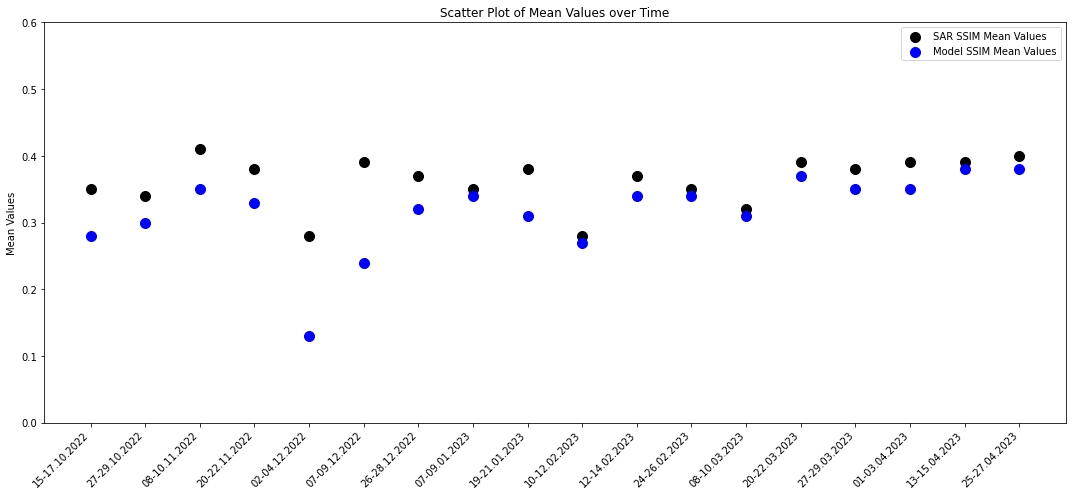

In [52]:
# Create a scatter plot
#plt.close(fig)
fig = plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
#plt.scatter(date_labels, sar_rpm_mean, color='red', s=100, label='SAR RPM Mean Values')
#plt.scatter(date_labels, mod_rpm_mean, color='orange', s=100, label='MOD RPM Mean Values')
plt.scatter(date_labels, sar_ssim_mean, color='black',s=100, label='SAR SSIM Mean Values')
plt.scatter(date_labels, mod_ssim_mean, color='blue',s=100, label='Model SSIM Mean Values')



# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 0.6])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

#save_plot(save_dir, "SSMI_change_without_gpi")
# Show the plot
plt.show()


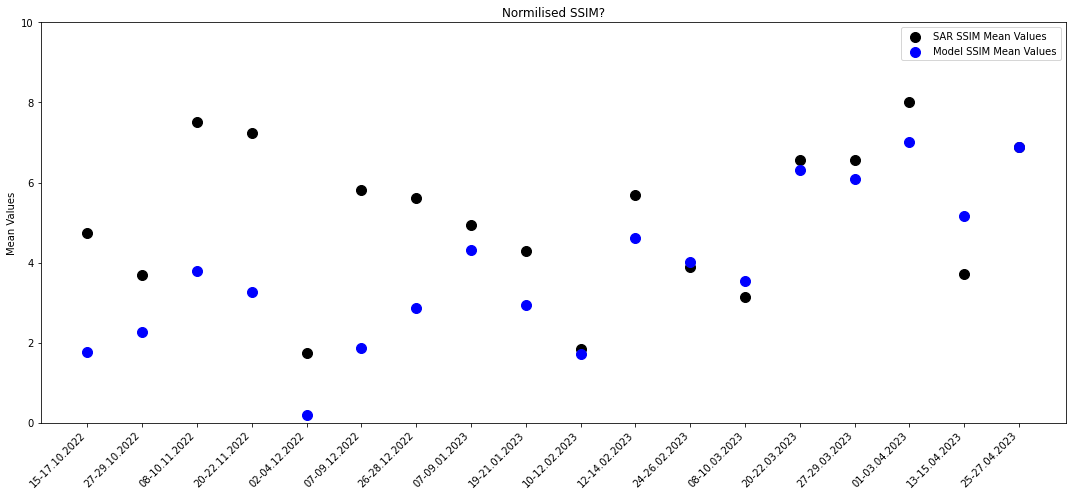

In [328]:
# Create a scatter plot
plt.close(fig)
fig = plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
#plt.scatter(date_labels, sar_rpm_mean, color='red', s=100, label='SAR RPM Mean Values')
#plt.scatter(date_labels, mod_rpm_mean, color='orange', s=100, label='MOD RPM Mean Values')
plt.scatter(date_labels, normalized_sar_ssim, color='black',s=100, label='SAR SSIM Mean Values')
plt.scatter(date_labels, normalized_mod_ssim, color='blue',s=100, label='Model SSIM Mean Values')



# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 10])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Normilised SSIM?')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

#save_plot(save_dir, "SSMI_change_without_gpi")
# Show the plot
plt.show()


In [321]:
diff_normalized = [a / b for a, b in zip(normalized_mod_ssim, normalized_sar_ssim)]

In [326]:
diff_normalized = [a / b for a, b in zip(mod_gpi_true_part_list, sar_gpi_true_part_list)] 

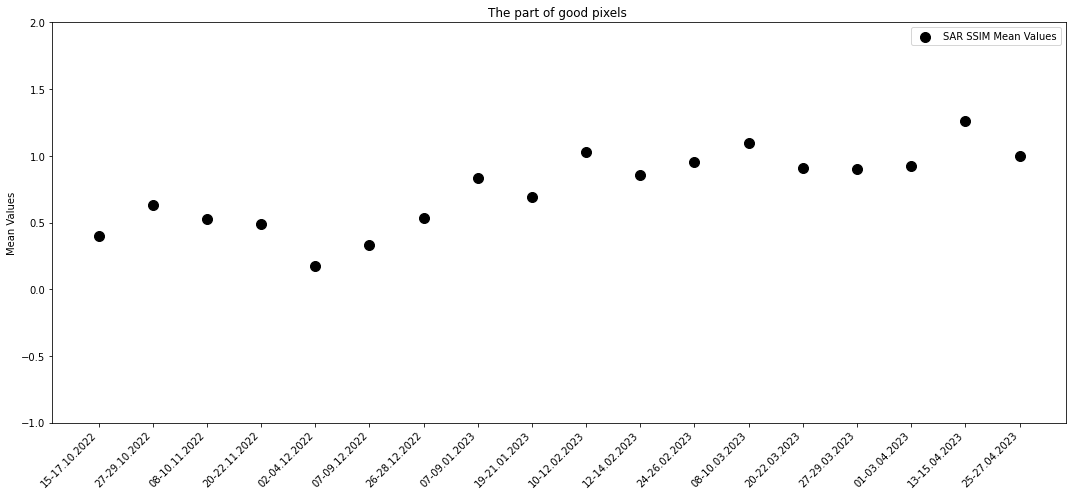

In [327]:
# Create a scatter plot
plt.close(fig)
fig = plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
#plt.scatter(date_labels, sar_rpm_mean, color='red', s=100, label='SAR RPM Mean Values')
#plt.scatter(date_labels, mod_rpm_mean, color='orange', s=100, label='MOD RPM Mean Values')
plt.scatter(date_labels, diff_normalized, color='black',s=100, label='SAR SSIM Mean Values')
#plt.scatter(date_labels, normalized_mod_ssim, color='blue',s=100, label='Model SSIM Mean Values')



# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([-1, 2])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('The part of good pixels ')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

#save_plot(save_dir, "SSMI_change_without_gpi")
# Show the plot
plt.show()


In [166]:
# Calculate Relative Root Mean Square Error (RRMSE) for each date
rrmse_list = []

for i in range(len(timestamps)):
    rrmse_values = np.sqrt(((mod_ssim_mean[i] - sar_ssim_mean[i]) ** 2)) / sar_ssim_mean[i]
    rrmse_list.append(rrmse_values)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


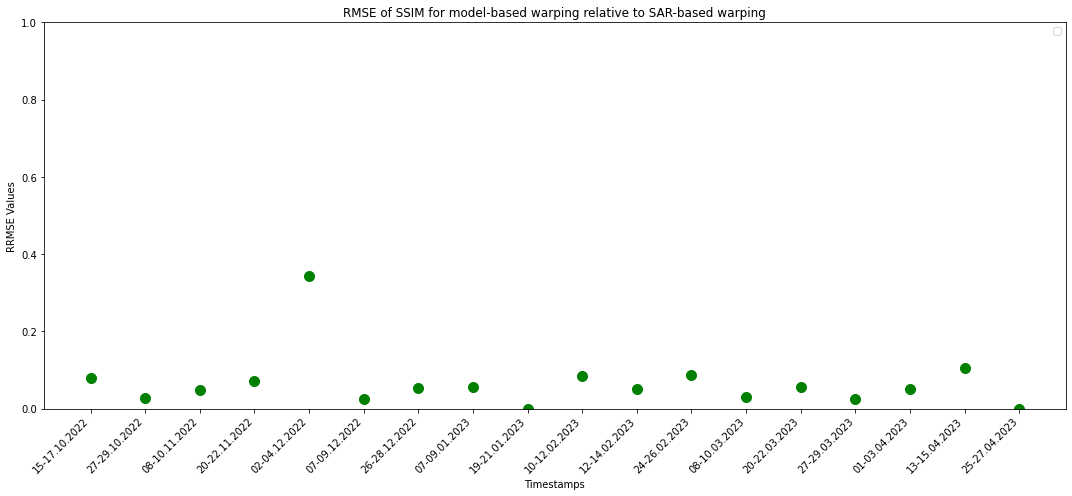

In [167]:
# Create a scatter plot
plt.close('all')  # Close any previously opened plots
fig = plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot RRMSE values
plt.scatter(date_labels, rrmse_list, color='green', s=100) #, label='RRMSE of MOD relative to SAR')

# Set the x-axis to use the date labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Since RRMSE can vary, we do not set a fixed y-axis limit as in the previous plot.
plt.ylim([0, 1])  # Adjust the limit based on the max RRMSE value

# Add labels and title to the plot
plt.xlabel('Timestamps')
plt.ylabel('RRMSE Values')
plt.title('RMSE of SSIM for model-based warping relative to SAR-based warping')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()
#save_plot(save_dir, "SSMI_difference")
# Show the plot
plt.show()

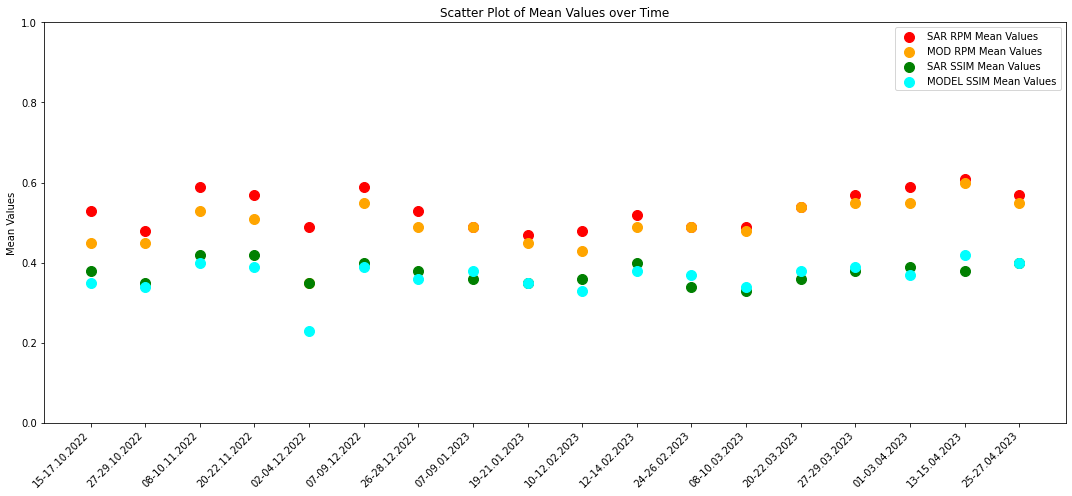

In [168]:
# Create a scatter plot

plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_rpm_mean, color='red', s=100, label='SAR RPM Mean Values')
plt.scatter(date_labels, mod_rpm_mean, color='orange', s=100, label='MOD RPM Mean Values')
plt.scatter(date_labels, sar_ssim_mean, color='green',s=100, label='SAR SSIM Mean Values')
plt.scatter(date_labels, mod_ssim_mean, color='cyan',s=100, label='MODEL SSIM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 1])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [188]:
# Calculate Relative Root Mean Square Error (RRMSE) for each date
diff_list = []

for i in range(len(timestamps)):
    diff = (mod_ssim_mean[i])
    diff_list.append(diff)

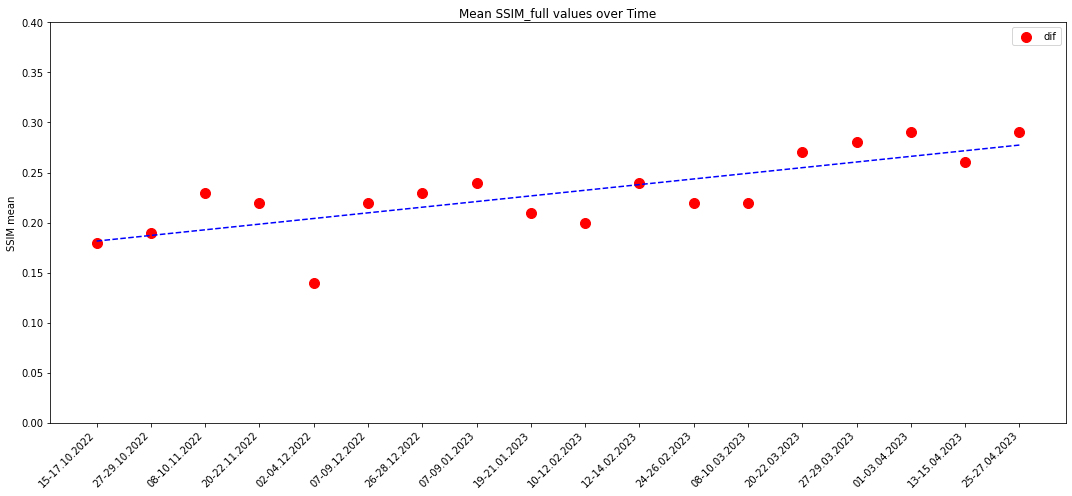

In [196]:
# Create a scatter plot

plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, mod_ssim_mean, color='red', s=100, label='dif')
#plt.scatter(date_labels, mod_rpm_mean-, color='orange', s=100, label='MOD RPM Mean Values')
#plt.scatter(date_labels, sar_ssim_mean-mod_ssim_mean, color='green',s=100, label='SAR SSIM Mean Values')
#plt.scatter(date_labels, mod_ssim_mean, color='cyan',s=100, label='MOD SSIM Mean Values')

# Convert date labels to numerical values for trend line calculation
dates_numeric = np.arange(len(date_labels))

#Adding a trend line
z = np.polyfit(dates_numeric, diff_list, 1)
p = np.poly1d(z)
plt.plot(date_labels, p(dates_numeric), "b--")

# Add horizontal axis at y=0
plt.axhline(0, color='black', linewidth=0.8)



# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 0.4])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('SSIM mean')
plt.title('Mean SSIM_full values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

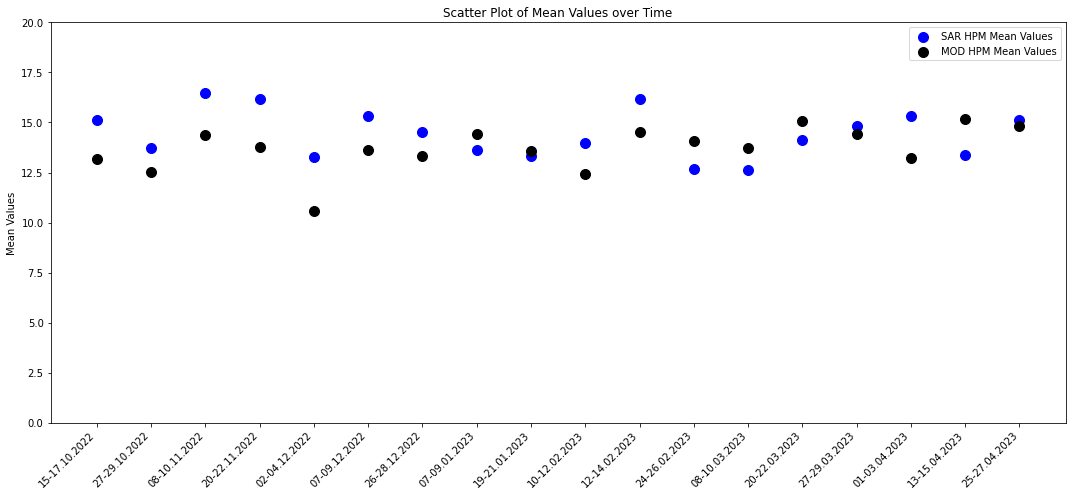

In [172]:

# Create a scatter plot
plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_hpm_mean, color='blue', s=100, label='SAR HPM Mean Values')
plt.scatter(date_labels, mod_hpm_mean, color='black', s=100, label='MOD HPM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 20])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Import and compare values for ssmi (masked with warped gpi), model ssim total, model ssim (masked with good hessian 8) - (no ft, ft, combined)

## 3. Plotting distortion arrays for one scene (masked)

In [53]:
import sys
sys.path.append("./modules")



# Import general modules
from nansat import Nansat, Domain, NSR
import os 
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta

# Import temporal modules needed for testing plotting
import matplotlib.pyplot as plt
#%matplotlib inline

from osgeo import gdal
from osgeo import osr
from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Import SAR forecasting modules
import config
import s1_preparation
import domains_preparation

# Import variables
from config import path_to_HH_files, path_to_HV_files, safe_folder 
from config import output_folder, input_folder
from config import S1_prod_regex, S1_safe_regex
from config import lon, lat, X, Y, proj4, srs
from config import hessian, neighbors
from config import disp_legend_min
from config import disp_legend_max

# For cleaning up memory
import gc

import cProfile
import pstats
from io import StringIO

# For ignoring some warnings
import warnings
# Ignore the runtime warnings related to 'Mean of empty slice' wen calculate rolling average
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')

#======================================================================
# 1. Prepare SAR pairs
#----------------------------------------------------------------------

# Collect Sentinel SAFE objects for files in safe directory.
safe_objects = s1_preparation.collect_sentinel_files(safe_folder, path_to_HH_files, path_to_HV_files,  S1_safe_regex, S1_prod_regex)

# Get pairs of Sentinel SAFE objects where their timestamps are within 50 hours of each other.
sar_pairs = s1_preparation.get_pairs_within_time_limit(safe_objects, hours = 50)

# Print details for each pair.
for index, pair in enumerate(sar_pairs, start=1):  # start=1 makes the index start from 1
    print(f'Pair {index}:')
    print(f'SAR1: {pair[0].filename} \ntimestamp: {pair[0].timestamp}\n'
          f'SAR2: {pair[1].filename} \ntimestamp: {pair[1].timestamp}')

Pair 1:
SAR1: S1A_EW_GRDM_1SDH_20221015T080155_20221015T080259_045450_056F5F_4931.SAFE 
timestamp: 2022-10-15 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221017T074535_20221017T074640_045479_057031_AB63.SAFE 
timestamp: 2022-10-17 07:45:35
Pair 2:
SAR1: S1A_EW_GRDM_1SDH_20221027T080155_20221027T080300_045625_05748D_80A7.SAFE 
timestamp: 2022-10-27 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221029T074535_20221029T074640_045654_057597_EC14.SAFE 
timestamp: 2022-10-29 07:45:35
Pair 3:
SAR1: S1A_EW_GRDM_1SDH_20221108T080155_20221108T080259_045800_057A7E_B070.SAFE 
timestamp: 2022-11-08 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221110T074535_20221110T074639_045829_057B80_E17B.SAFE 
timestamp: 2022-11-10 07:45:35
Pair 4:
SAR1: S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1.SAFE 
timestamp: 2022-11-20 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221122T074535_20221122T074639_046004_05816B_9FC9.SAFE 
timestamp: 2022-11-22 07:45:35
Pair 5:
SAR1: S1A_EW_GRDM_1SDH_20221202T080154_20221202T080258_046150_058653_D0B

In [54]:
# For selected pair create nansat objects

f1 = sar_pairs[0][0].filepath  
f2 = sar_pairs[0][1].filepath


n1 = get_n(f1, bandName= f'sigma0_HV', remove_spatial_mean=True) 
n2 = get_n(f2, bandName= f'sigma0_HV', remove_spatial_mean=True)

VMIN:  -3.8404658794403073
VMAX:  5.989928512573236
VMIN:  -4.566331052780152
VMAX:  6.231645169258117


In [181]:
import warping_with_domain
mask_u = np.isnan(u_b_list[0])
mask_v = np.isnan(v_b_list[0])
mask = mask_u & mask_v # mask out low quality or NaN
    
s1_dst_dom_S_hv = warping_with_domain.warp_with_uv(n1, n1[1], mod_dom, u_b_list[0], v_b_list[0], mask, dst_dom)

In [182]:
# Warp SAR2 to the comparison domain
s2_dst_dom_hv = warping_with_domain.warp(n1, n1[1], dst_dom)

# Warp SAR1 to the comparison domain for visualisation
s1_dst_dom_hv = warping_with_domain.warp(n1, n1[1], dst_dom)

In [183]:
# Convert the entire array to float
sar2_predicted_float = s1_dst_dom_S_hv.astype(float)

# Replace 0 with NaN
sar2_predicted_float[sar2_predicted_float == 0] = np.nan

In [179]:
# Convert the entire array to float
sar2_real_float = s2_dst_dom_hv.astype(float)

# Replace 0 with NaN
sar2_real_float[sar2_real_float == 0] = np.nan

In [186]:
nansat_sar2_predicted = Nansat.from_domain(dst_dom, array = sar2_predicted_float)
nansat_sar2_real = Nansat.from_domain(dst_dom, array = sar2_real_float)

In [192]:
from sea_ice_drift.ftlib import feature_tracking
import sys
sys.path.append(r'./modules/sea_ice_drift')
from pmlib_with_ssim import pattern_matching

In [ ]:
# 5.3.1. Run feature tracking and plot results 
c1, r1, c2, r2 = feature_tracking(nansat_sar2_real, nansat_sar2_predicted, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)



error: OpenCV(4.6.0) /home/conda/feedstock_root/build_artifacts/libopencv_1658893724527/work/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [191]:

upm, vpm, apm, rpm, hpm, ssim, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, nansat_sar2_real, c1, r1, nansat_sar2_predicted, c2, r2,srs, 
                                                                 min_border=10,
                                                                 max_border=10,
                                                                 angles=[-15,-12,-9,-6, -3, 0, 3, 6, 9, 12, 15])

error: OpenCV(4.6.0) /home/conda/feedstock_root/build_artifacts/libopencv_1658893724527/work/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [56]:
# Replace 0 with NaN
float_array = n1[1].astype(float)
nan_array = float_array[float_array == 0] = np.nan

In [57]:
# Convert the entire array to float
n1_float = n1[1].astype(float)

# Replace 0 with NaN
n1_float[n1_float == 0] = np.nan

In [59]:
nansat_2 = Nansat.from_domain(dst_dom, array = n1_float)

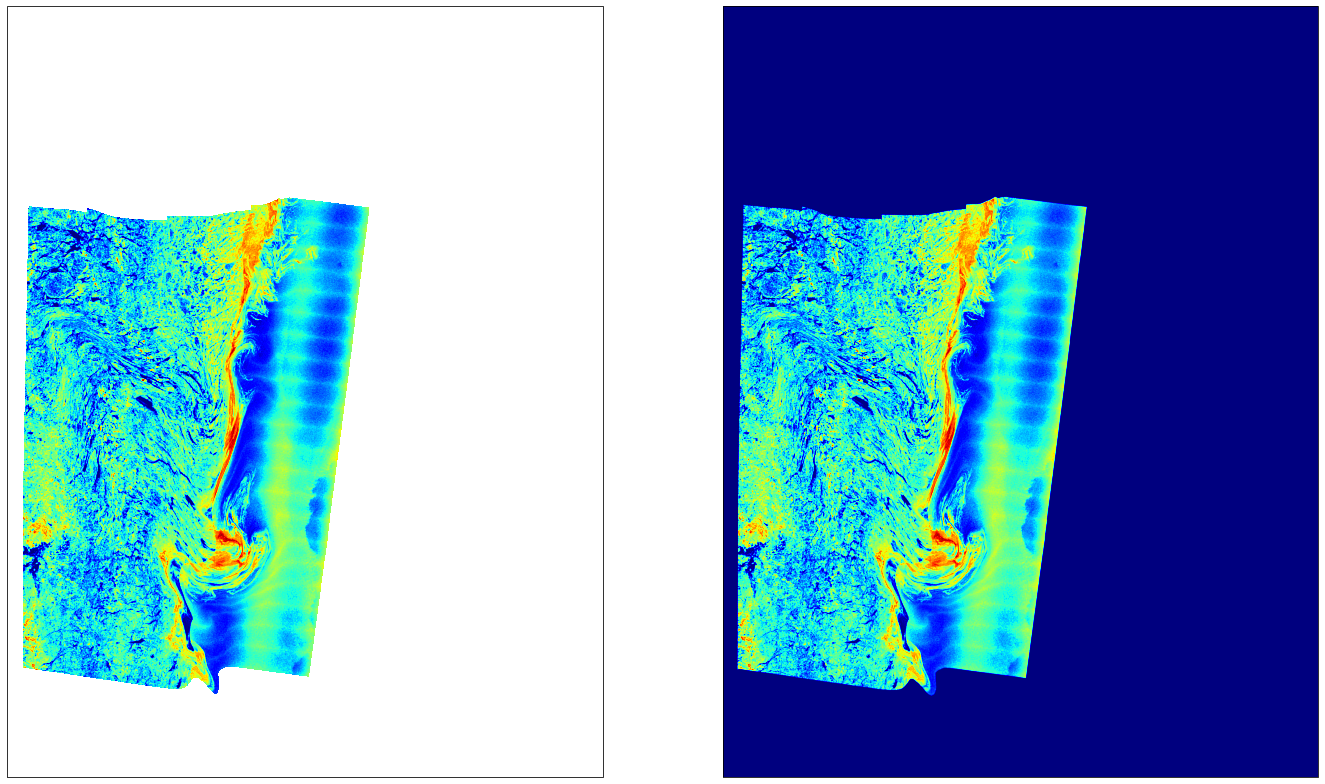

In [199]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(nansat_sar2_predicted[1] , cmap='jet', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
image2 = ax2.imshow(s1_dst_dom_S_hv , cmap='jet', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

#ax1.set_xlim([x.min(), x.max()-79000])
#ax1.set_ylim([y.min()+100000, y.max()-150000])
#ax2.set_xlim([x.min(), x.max()-79000])
#ax2.set_ylim([y.min()+100000, y.max()-150000])
#plt.colorbar(image1, ax=ax1, shrink=0.5)
#plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


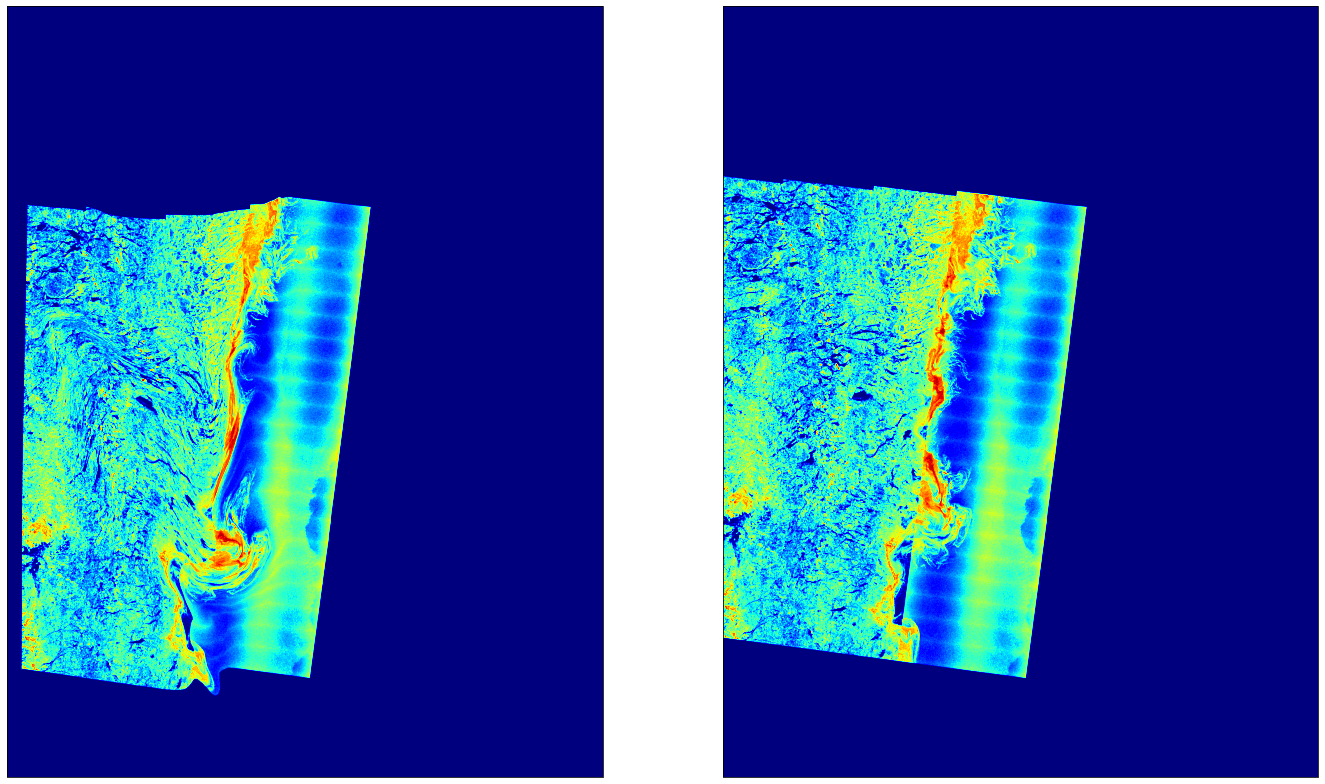

In [173]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(s1_dst_dom_S_hv , cmap='jet', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
image2 = ax2.imshow(s2_dst_dom_hv, cmap='jet', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

#ax1.set_xlim([x.min(), x.max()-79000])
#ax1.set_ylim([y.min()+100000, y.max()-150000])
#ax2.set_xlim([x.min(), x.max()-79000])
#ax2.set_ylim([y.min()+100000, y.max()-150000])
#plt.colorbar(image1, ax=ax1, shrink=0.5)
#plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


In [63]:
from scipy.ndimage import convolve
def get_good_pixel_indices(hpm, h_threshold, neighbors_threshold):
    """
    Get good pixel indices based on hessian and neighbor thresholds.

    Parameters:
    - hpm: Hessian processed matrix
    - h_threshold: Threshold for the hessian value
    - neighbors_threshold: Threshold for the number of valid neighboring pixels

    Returns:
    - gpi1: Good pixel index based on hessian value
    - gpi2: Good pixel index combining hessian and neighbors count
    """
    
    # Filtering arrays with hessian first, then excluding pixels with no neighbors
    filtered_hpm = np.where(hpm > h_threshold, hpm, np.nan)
    
    # Define a kernel to count neighbors
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])

    # Convert nan values to 1 and valid values to 0
    nan_mask = np.isnan(filtered_hpm).astype(int)

    # Count nan neighbors
    nan_neighbors = convolve(nan_mask, kernel, mode='constant')

    # Count valid neighbors by subtracting nan neighbors from total neighbors (8 for a 3x3 kernel)
    valid_neighbors = 8 - nan_neighbors

    # Mask out pixels with zero valid neighbors
    filtered_hpm[valid_neighbors < neighbors_threshold] = np.nan

    # Filter vectors with hessian value
    gpi1 = (hpm > h_threshold)
    gpi2 = (hpm > h_threshold) & (valid_neighbors >= neighbors_threshold)
    
    return gpi1, gpi2

In [395]:

i = 17

In [396]:
timestamps[i]

'20230425T080152_20230427T074532'

In [397]:

# Hessian filter  for good pixel index (gpi1) based on hessian value
hessian=0.3 #13

# Number of neighbors filter gpi2 combining hessian and neighbors with drift values count
neighbors = 4

gpi_sar, gpi_sar = get_good_pixel_indices(sar_ssim_list_400_50[i] , h_threshold=hessian, neighbors_threshold=neighbors) #sar_warped_mask_list is warped hpm  sar_warped_mask_list[i] sar_ssim_list_400_50

# Hessian filter  for good pixel index (gpi1) based on hessian value
hessian=0.35 #8

# Number of neighbors filter gpi2 combining hessian and neighbors with drift values count
neighbors=2


gpi_mod, gpi_mod = get_good_pixel_indices(mod_ssim_list_400_50[i], h_threshold=hessian, neighbors_threshold=neighbors) #mod_hpm_list_400_50


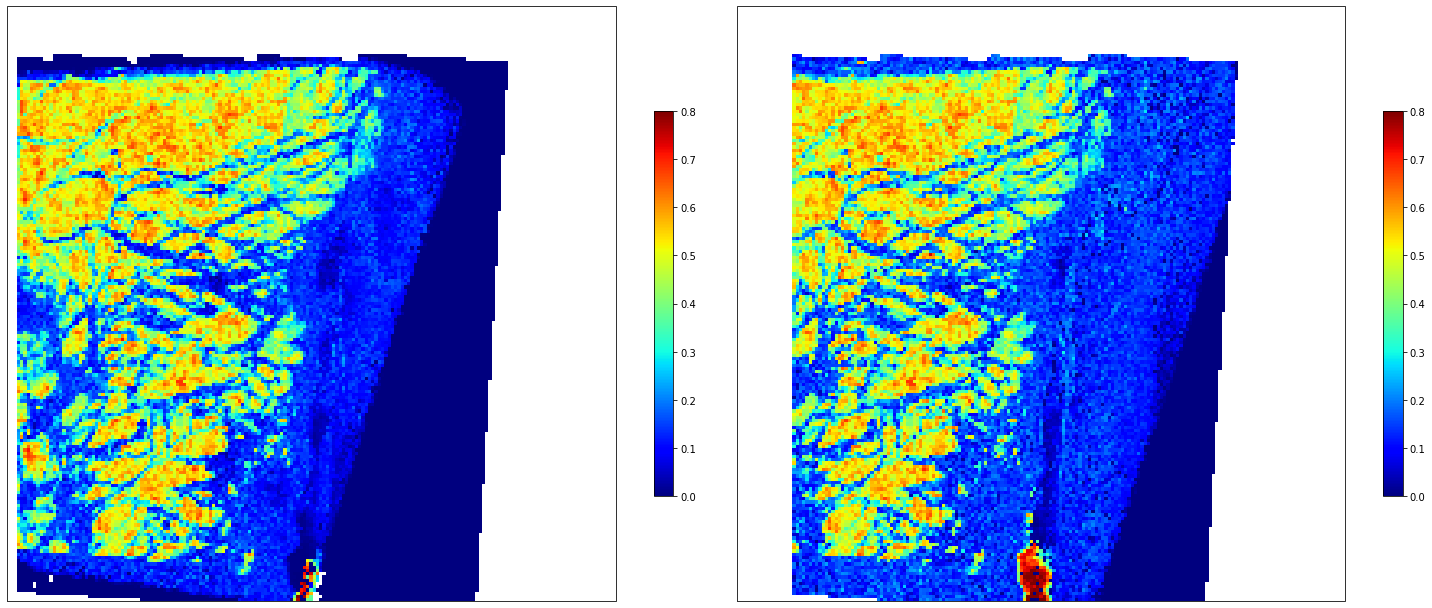

In [362]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(sar_ssim_list_50_12[i], cmap='jet', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin=0, vmax=0.8)
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
image2 = ax2.imshow(sar_ssim_list_400_50[i], cmap='jet', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin=0, vmax=0.8)
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


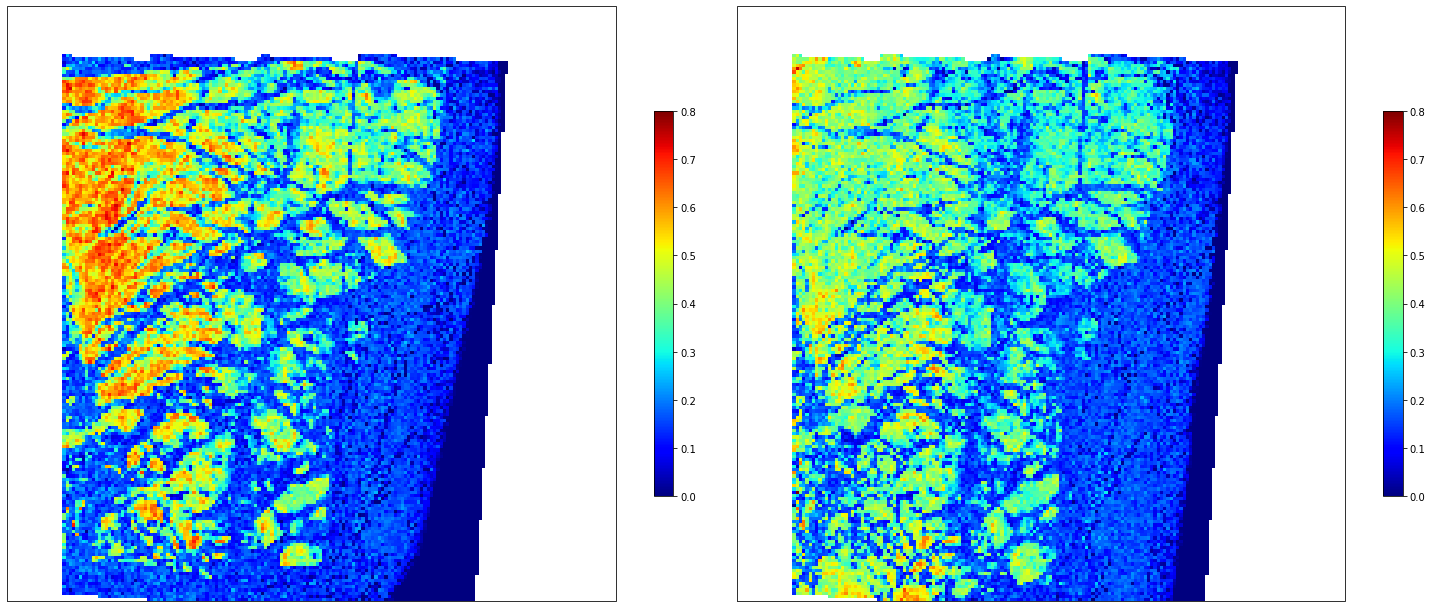

In [76]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(sar_ssim_list_400_50[i] , cmap='jet', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin=0, vmax=0.8) #mod_ssim_list_50_12[i]
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
image2 = ax2.imshow(mod_ssim_list_400_50[i], cmap='jet', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin=0, vmax=0.8)
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


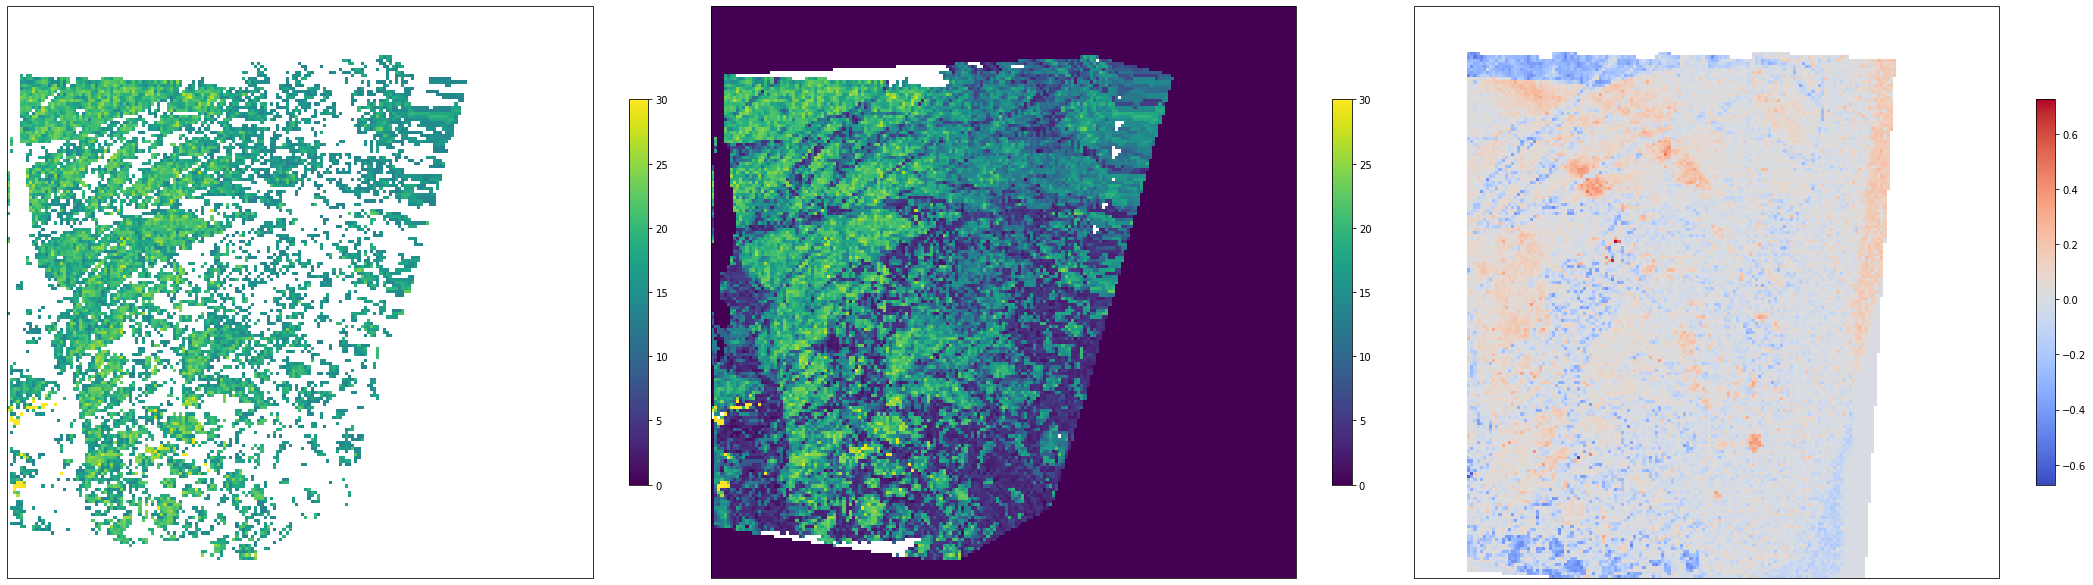

In [398]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,11), subplot_kw={'projection': crs})

sar_filtered = np.where( sar_warped_mask_list[i]>13 , sar_warped_mask_list[i]  , np.nan) #sar_warped_mask_list[i]>13 sar_ssim_list_400_50[i]
img1 = ax1.imshow(sar_filtered , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 30)
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#mod_filtered = np.where(gpi_sar, sar_ssim_list_400_50[i], np.nan)
mod_filtered = np.where(gpi_mod, mod_ssim_list_400_50[i], np.nan)
#img2 = ax2.imshow( mod_filtered, cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
img2 = ax2.imshow( sar_warped_mask_list[i],  cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 30) 
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
img3 = ax3.imshow((sar_ssim_list_400_50[i] - mod_ssim_list_400_50[i]), cmap='coolwarm', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)
plt.colorbar(img2, ax=ax2, shrink=0.5)
plt.colorbar(img3, ax=ax3, shrink=0.5)
plt.tight_layout()
plt.show()


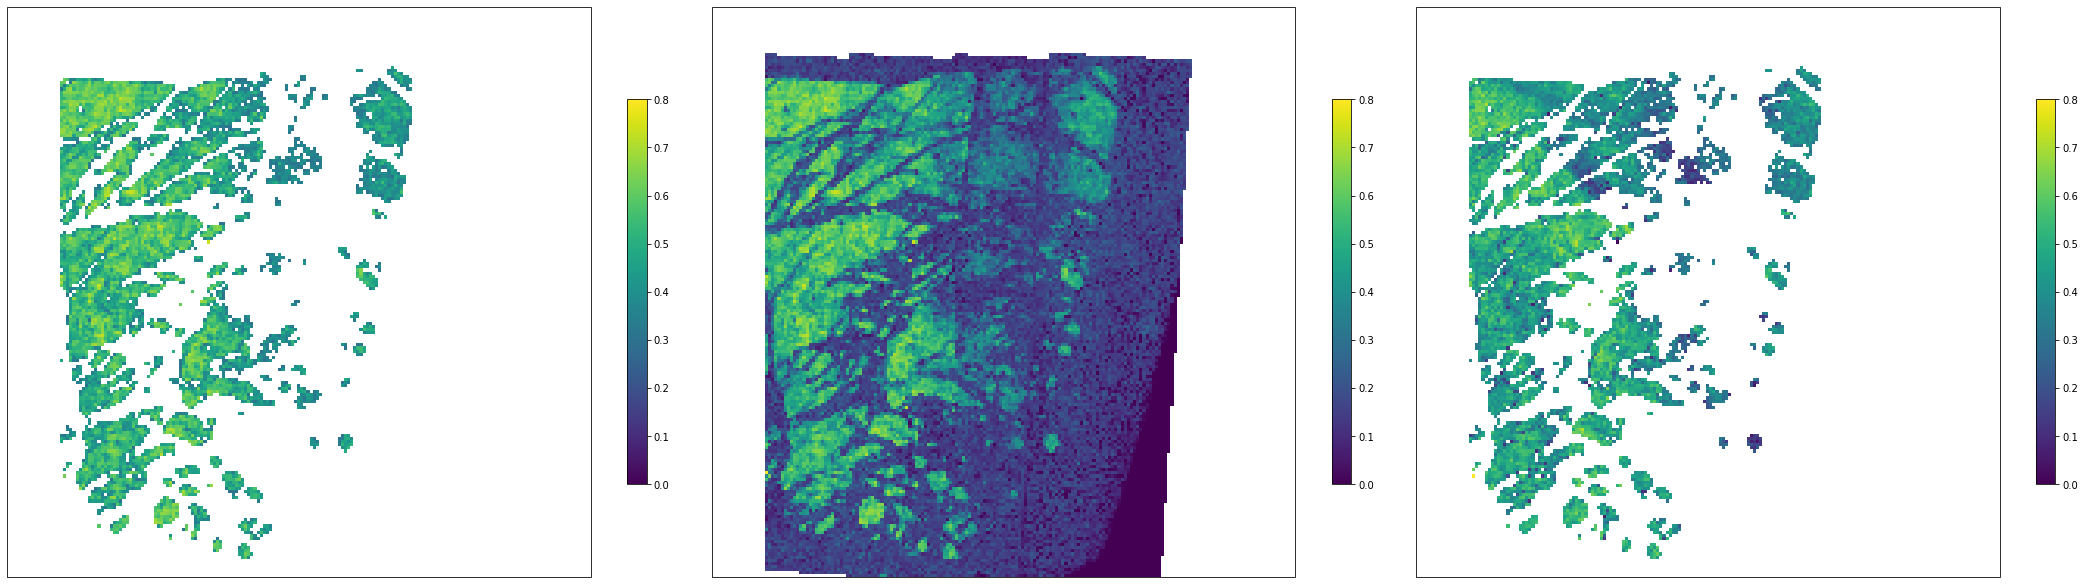

In [399]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,11), subplot_kw={'projection': crs})

sar_filtered = np.where( gpi_sar , sar_ssim_list_400_50[i], np.nan) #sar_warped_mask_list[i]>13
img1 = ax1.imshow(sar_filtered , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()] , vmin = 0, vmax = 0.8)
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#mod_filtered = np.where(gpi_sar, sar_ssim_list_400_50[i], np.nan)

#img2 = ax2.imshow( mod_filtered, cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
img2 = ax2.imshow( sar_ssim_list_400_50[i],  cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 0.8) #, vmin = 0, vmax = 30) sar_warped_mask_list[i],
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
mod_filtered = np.where(gpi_sar, mod_ssim_list_400_50[i], np.nan)
img3 = ax3.imshow( mod_filtered,  cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 0.8)
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)
plt.colorbar(img2, ax=ax2, shrink=0.5)
plt.colorbar(img3, ax=ax3, shrink=0.5)
plt.tight_layout()
plt.show()


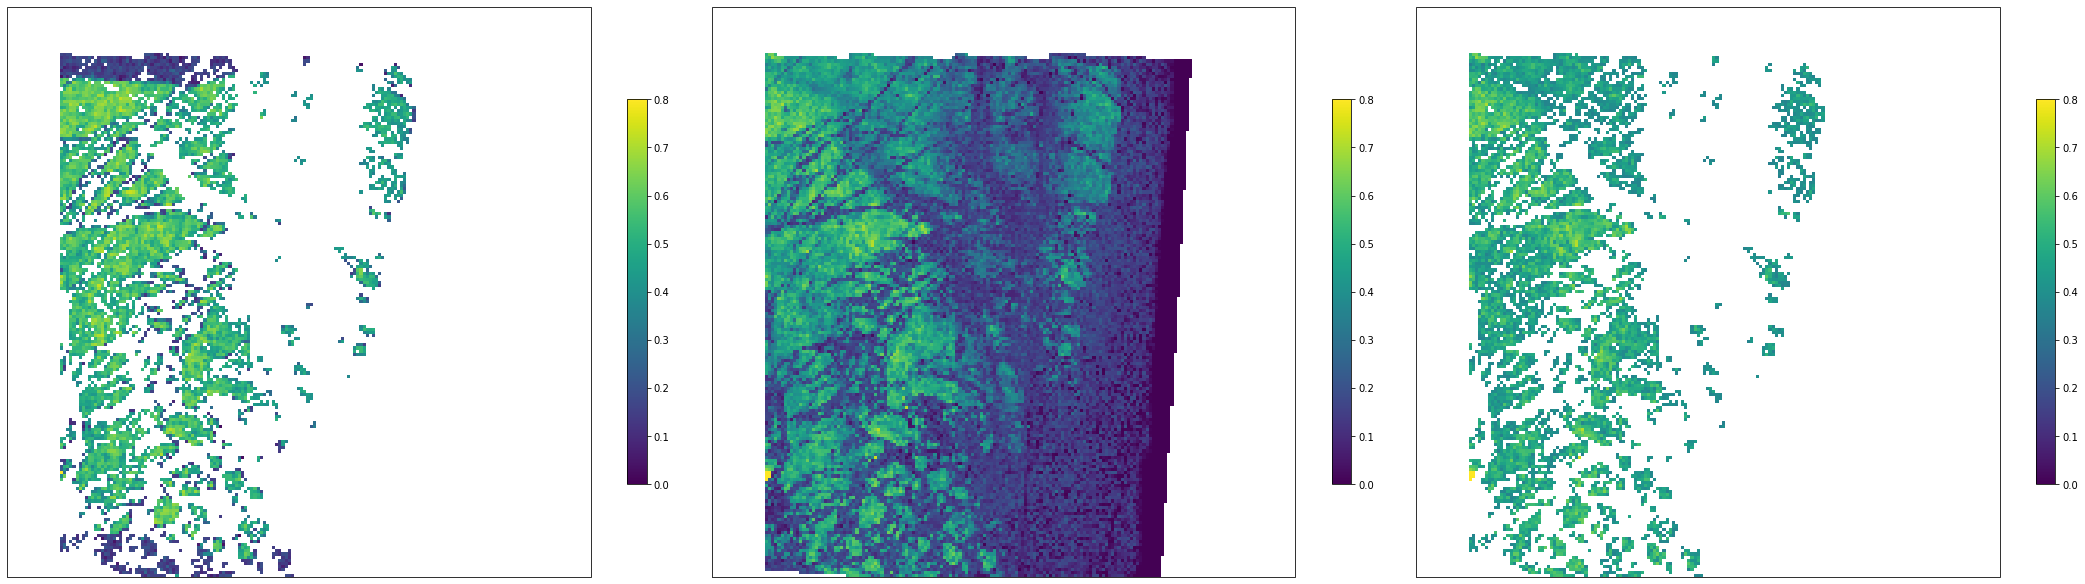

In [400]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,11), subplot_kw={'projection': crs})

sar_filtered = np.where( gpi_mod , sar_ssim_list_400_50[i], np.nan) #sar_warped_mask_list[i]>13
img1 = ax1.imshow(sar_filtered , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()] , vmin = 0, vmax = 0.8)
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#mod_filtered = np.where(gpi_sar, sar_ssim_list_400_50[i], np.nan)

#img2 = ax2.imshow( mod_filtered, cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
img2 = ax2.imshow( mod_ssim_list_400_50[i],  cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 0.8) #, vmin = 0, vmax = 30) sar_warped_mask_list[i],
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
mod_filtered = np.where(gpi_mod, mod_ssim_list_400_50[i], np.nan)
img3 = ax3.imshow( mod_filtered,  cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 0.8)
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)
plt.colorbar(img2, ax=ax2, shrink=0.5)
plt.colorbar(img3, ax=ax3, shrink=0.5)
plt.tight_layout()
plt.show()


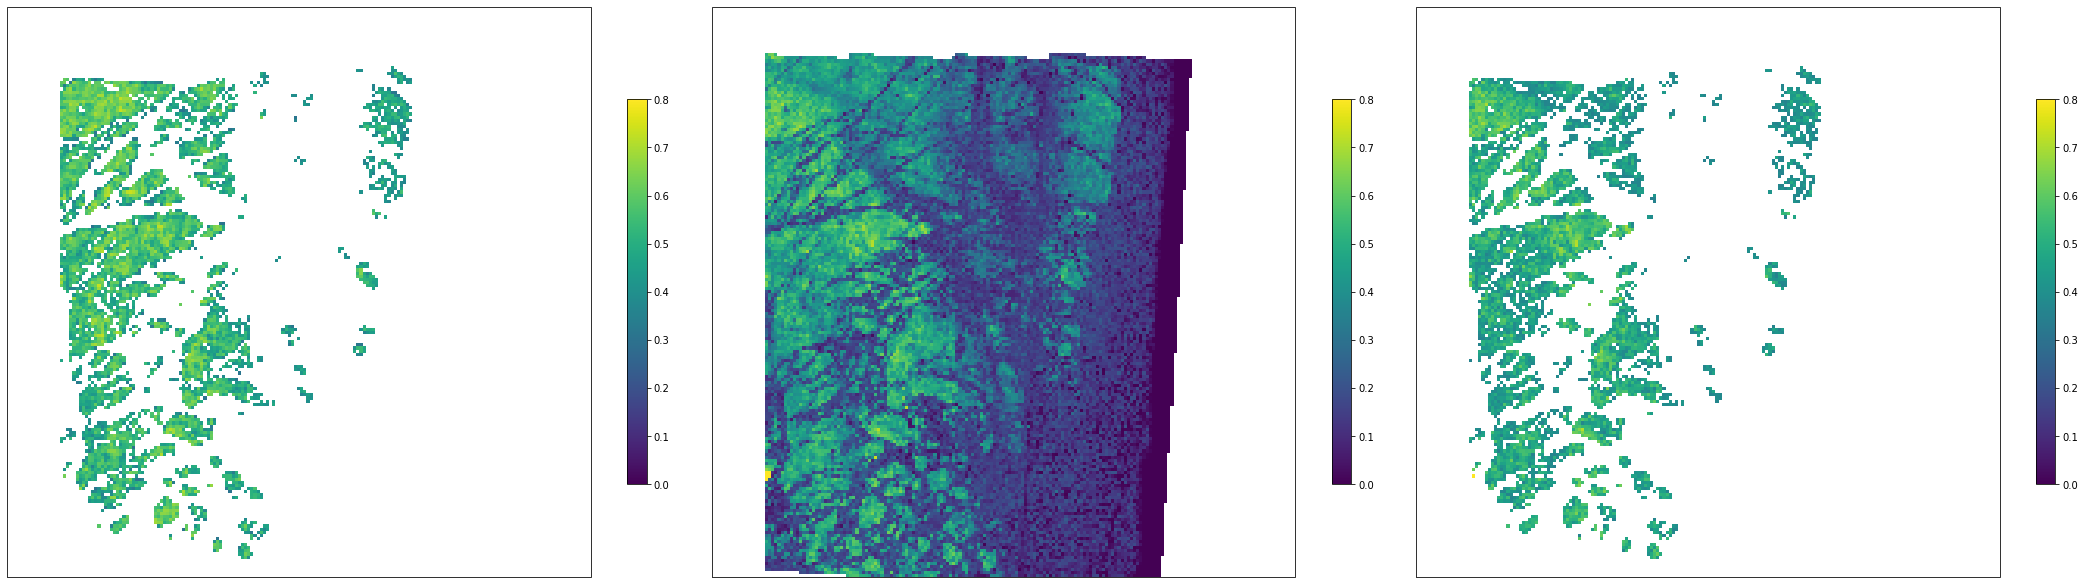

In [401]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,11), subplot_kw={'projection': crs})

sar_filtered = np.where( gpi_mod&gpi_sar , sar_ssim_list_400_50[i], np.nan) #sar_warped_mask_list[i]>13
img1 = ax1.imshow(sar_filtered , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()] , vmin = 0, vmax = 0.8)
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#mod_filtered = np.where(gpi_sar, sar_ssim_list_400_50[i], np.nan)

#img2 = ax2.imshow( mod_filtered, cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
img2 = ax2.imshow( mod_ssim_list_400_50[i],  cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 0.8) #, vmin = 0, vmax = 30) sar_warped_mask_list[i],
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
mod_filtered = np.where(gpi_mod&gpi_sar, mod_ssim_list_400_50[i], np.nan)
img3 = ax3.imshow( mod_filtered,  cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 0.8)
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)
plt.colorbar(img2, ax=ax2, shrink=0.5)
plt.colorbar(img3, ax=ax3, shrink=0.5)
plt.tight_layout()
plt.show()


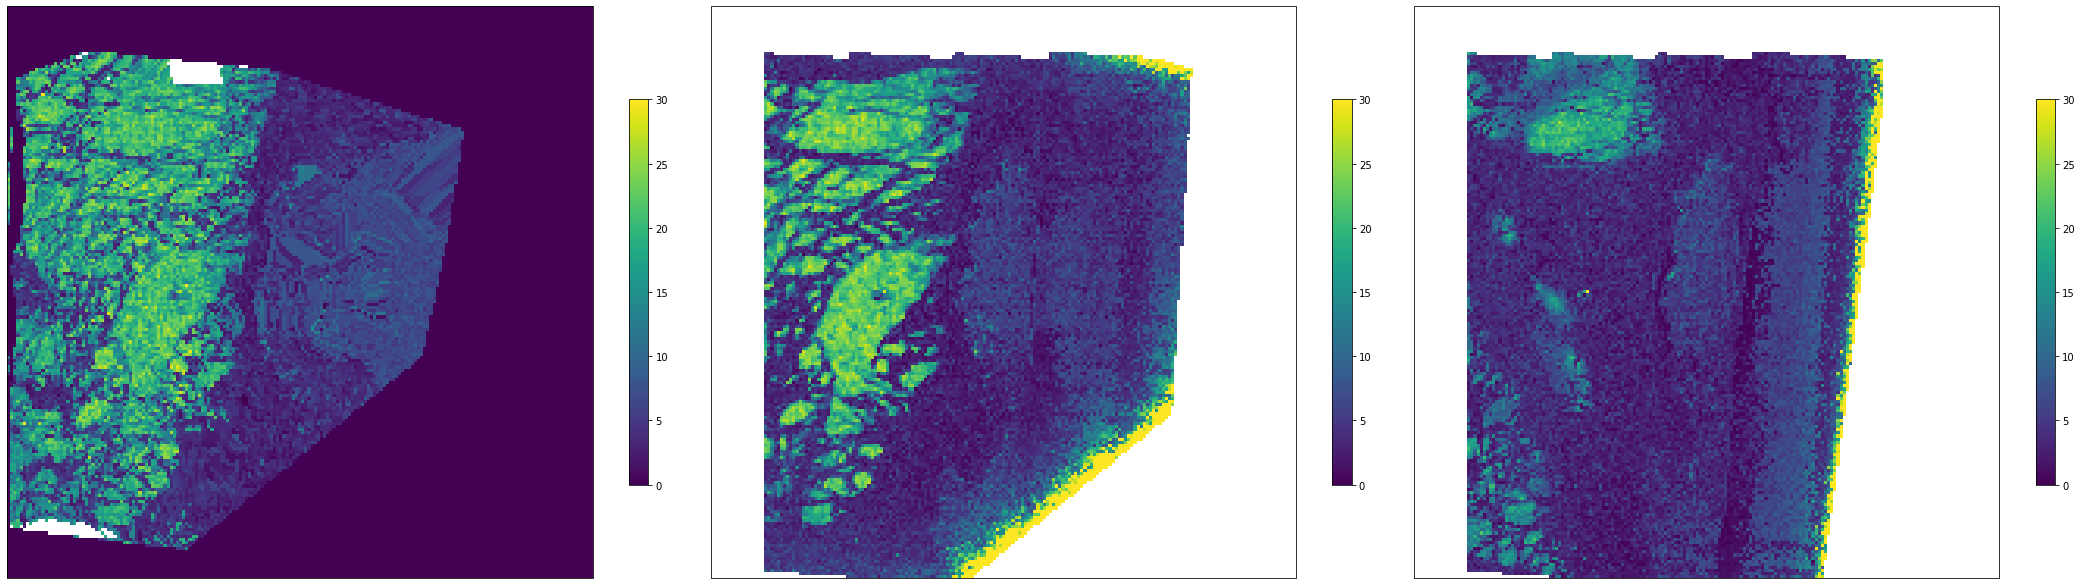

In [276]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,11), subplot_kw={'projection': crs})

sar_filtered = np.where(sar_warped_mask_list[i]>8, sar_ssim_list_400_50[i], np.nan) #sar_warped_mask_list[i] 
img1  = ax1.imshow( sar_warped_mask_list[i], cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 30) #sar12_hpm_list
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#mod_filtered = np.where(gpi_sar, sar_ssim_list_400_50[i], np.nan)
mod_filtered = np.where(gpi_mod, mod_ssim_list_400_50[i], np.nan)
#img2 = ax2.imshow( mod_filtered, cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
img2 = ax2.imshow( sar_hpm_list_400_50[i], cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 30)
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
img3 = ax3.imshow( mod_hpm_list_400_50[i], cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 30)
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)
plt.colorbar(img2, ax=ax2, shrink=0.5)
plt.colorbar(img3, ax=ax3, shrink=0.5)
plt.tight_layout()
plt.show()


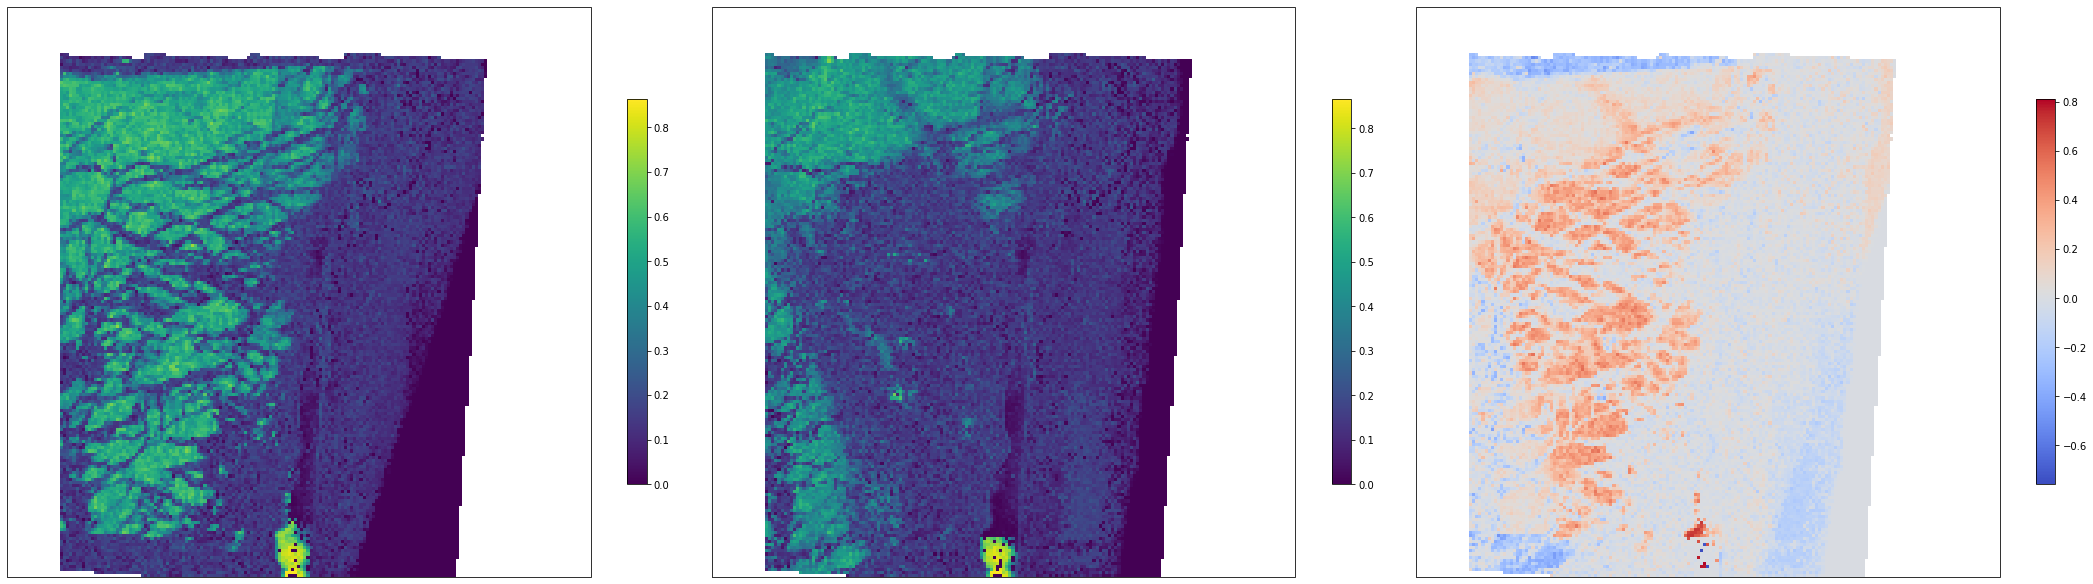

In [131]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,11), subplot_kw={'projection': crs})

#sar_filtered = np.where(gpi_sar, sar_ssim_list_400_50[i], np.nan) #sar_warped_mask_list[i]
img1 = ax1.imshow(sar_ssim_list_400_50[i] , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#img1 = ax1.imshow(sar_filtered , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#mod_filtered = np.where(gpi_sar, sar_ssim_list_400_50[i], np.nan)
#mod_filtered = np.where(gpi_mod, mod_ssim_list_400_50[i], np.nan)
img2 = ax2.imshow( mod_ssim_list_400_50[i], cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#img2 = ax2.imshow( mod_filtered, cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
img3 = ax3.imshow((sar_ssim_list_400_50[i] - mod_ssim_list_400_50[i]), cmap='coolwarm', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)
plt.colorbar(img2, ax=ax2, shrink=0.5)
plt.colorbar(img3, ax=ax3, shrink=0.5)
plt.tight_layout()
plt.show()


NameError: name 'dst_img' is not defined

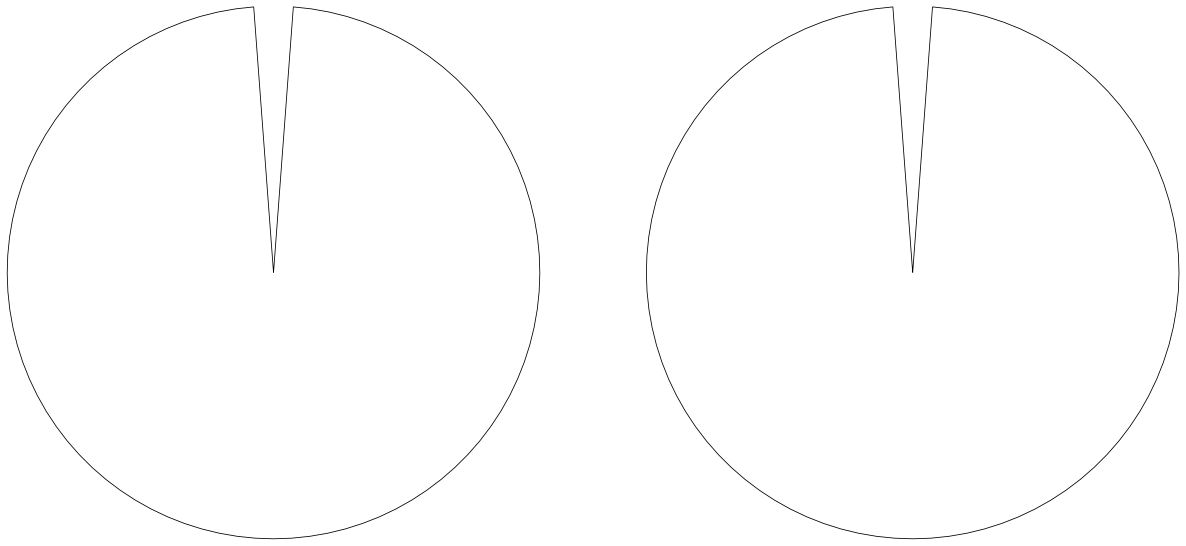

In [115]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
masked_warp_gpi = sar_warped_mask_list[0]
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

ax1.imshow(dst_img, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
ax2.imshow(dst_img2, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
ax2.imshow(masked_warp_gpi, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.tight_layout()
plt.show()


NameError: name 'mod_hpm_list' is not defined

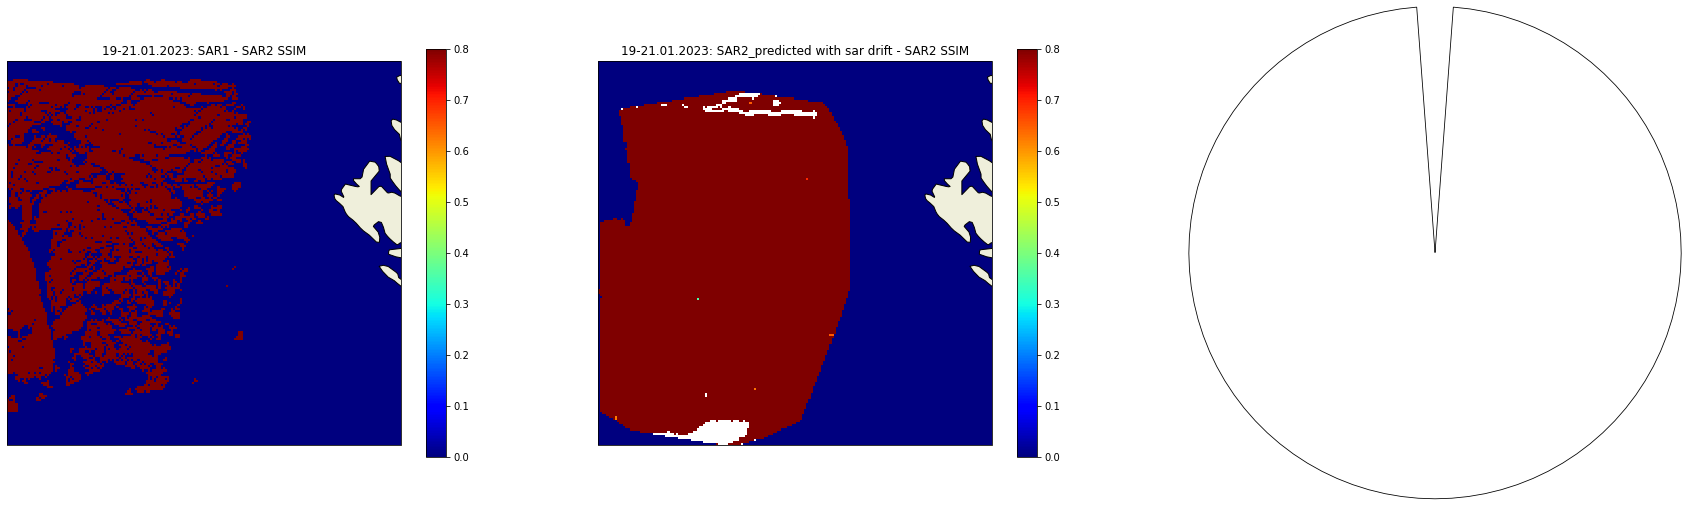

In [108]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

i = 8
gpi =  gpi2_list[i] #gpi_mod_warp #gpi_sar_warp #
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor=cfeature.COLORS['land'])

# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,15), subplot_kw={'projection': crs})

# Figure 1



#sar_filtered1 = np.where(gpi, sar12_ssim_list[i], np.nan)
#img1 = ax1.imshow(sar_filtered1, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img1 = ax1.imshow(gpi2_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8, interpolation='nearest')
ax1.set_title(f'{date_labels[i]}: SAR1 - SAR2 SSIM')

ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)

# Figure 2

mod_filtered = np.where(sar_warped_mask_list[8], sar_ssim_list_400_50[i], np.nan)
#sar_filtered2 = np.where(dst_img, sar_ssim_list[i], np.nan)
#img2 = ax2.imshow(warp_gpi, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper')
#img2 = ax2.imshow(dst_img, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)#
img2 = ax2.imshow(sar_warped_mask_list[8], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=1, interpolation='nearest')
ax2.set_title(f'{date_labels[i]}: SAR2_predicted with sar drift - SAR2 SSIM')

ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax2, shrink=0.5)

# Figure 3

#ax2.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
gpi_mod = (mod_hpm_list[i]>8)
mod_true_count = np.count_nonzero(gpi_mod)
print(mod_true_count)
mod_filtered = np.where(gpi_mod, mod_ssim_list[i], np.nan)
#img3 = ax3.imshow(mod_filtered, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img3 = ax3.imshow(mod_filtered, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8, interpolation='nearest')
ax3.set_title(f'{date_labels[i]}: SAR2_predicted with model drift - SAR2 SSIM')
ax3.add_feature(land_50m, edgecolor='black')
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img2, ax=ax3, shrink=0.5)





plt.tight_layout()
plt.show()


NameError: name 'sar12_ssim_list_400_50' is not defined

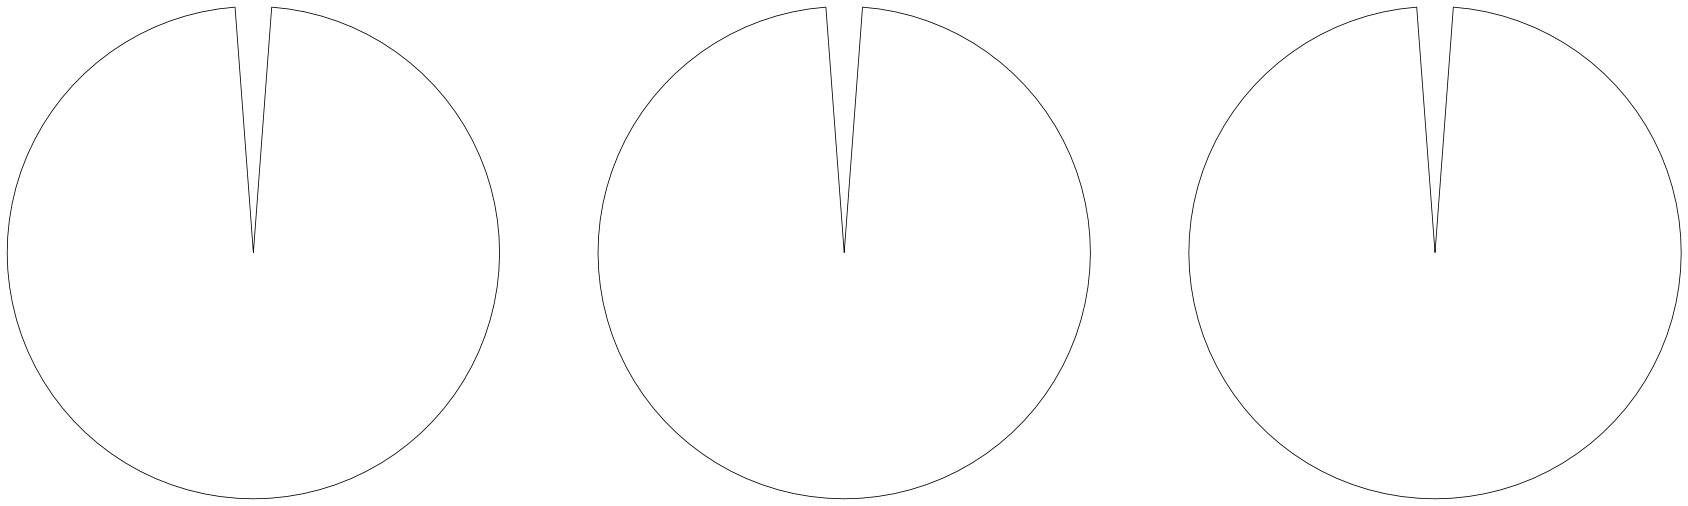

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

i = 1
gpi =  gpi2_list[i] #gpi_mod_warp #gpi_sar_warp #
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor=cfeature.COLORS['land'])

# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,15), subplot_kw={'projection': crs})

# Figure 1



#sar_filtered1 = np.where(gpi, sar12_ssim_list[i], np.nan)
#img1 = ax1.imshow(sar_filtered1, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img1 = ax1.imshow(sar12_ssim_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax1.set_title(f'{date_labels[i]}: SAR1 - SAR2 SSIM')

ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)

# Figure 2


#sar_filtered2 = np.where(dst_img, sar_ssim_list[i], np.nan)
#img2 = ax2.imshow(sar_filtered2, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)#
img2 = ax2.imshow(sar_ssim_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax2.set_title(f'{date_labels[i]}: SAR2_predicted with sar drift - SAR2 SSIM')

ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax2, shrink=0.5)

# Figure 3

#ax2.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')

#mod_filtered = np.where(gpi, mod_ssim_list[i], np.nan)
#img3 = ax3.imshow(mod_filtered, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img3 = ax3.imshow(mod_ssim_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax3.set_title(f'{date_labels[i]}: SAR2_predicted with model drift - SAR2 SSIM')
ax3.add_feature(land_50m, edgecolor='black')
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img2, ax=ax3, shrink=0.5)





plt.tight_layout()
plt.show()


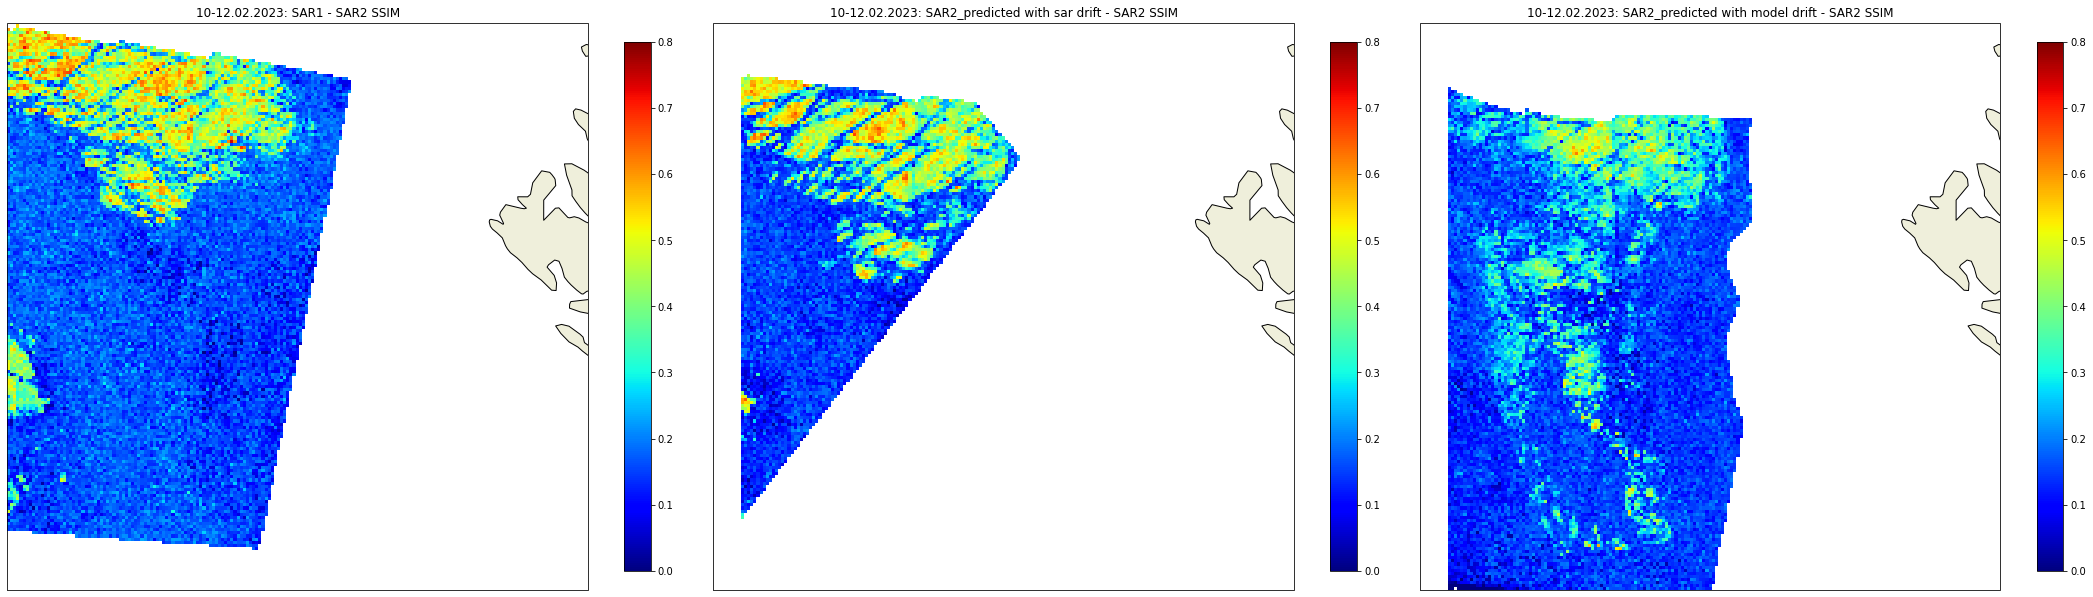

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

i = 9
gpi =  gpi2_list[i] #gpi_mod_warp #gpi_sar_warp #
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor=cfeature.COLORS['land'])

# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,15), subplot_kw={'projection': crs})

# Figure 1



sar_filtered1 = np.where(gpi, sar12_ssim_list[i], np.nan)
#img1 = ax1.imshow(sar_filtered1, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img1 = ax1.imshow(sar12_ssim_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax1.set_title(f'{date_labels[i]}: SAR1 - SAR2 SSIM')

ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)

# Figure 2


sar_filtered2 = np.where(gpi_sar_warp, sar_ssim_list[i], np.nan)
#img2 = ax2.imshow(sar_filtered2, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)#
img2 = ax2.imshow(sar_ssim_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax2.set_title(f'{date_labels[i]}: SAR2_predicted with sar drift - SAR2 SSIM')

ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax2, shrink=0.5)

# Figure 3

#ax2.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')

#mod_filtered = np.where(gpi, mod_ssim_list[i], np.nan)
#img3 = ax3.imshow(mod_filtered, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img3 = ax3.imshow(mod_ssim_not_ft_list[i] , extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8) #mod_ssim_list[i]
ax3.set_title(f'{date_labels[i]}: SAR2_predicted with model drift - SAR2 SSIM')
ax3.add_feature(land_50m, edgecolor='black')
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img2, ax=ax3, shrink=0.5)





plt.tight_layout()
plt.show()


In [41]:
# Importing distortion parametrs (between SAR2 real and SAR2 predictions)
mod_distor_folder_name = 'model_distort_error_data'
distor_variable_names = ['rpm', 'hpm', 'ssim']
mod_distor_data, timestamps = export_pm_output_data(parent_dir, mod_distor_folder_name, distor_variable_names)
    
mod_rpm_not_ft_list = mod_distor_data['rpm']
mod_hpm_not_ft_list = mod_distor_data['hpm']
mod_ssim_not_ft_list =mod_distor_data['ssim']

# Exporting distortion parametrs (between SAR2 real and SAR2 predictions)
mod_distor_folder_name = 'model_distort_error_data_ft'
distor_variable_names = ['rpm', 'hpm', 'ssim']
mod_distor_data, timestamps = export_pm_output_data(parent_dir, mod_distor_folder_name, distor_variable_names)
    
mod_rpm_ft_list = mod_distor_data['rpm']
mod_hpm_ft_list = mod_distor_data['hpm']
mod_ssim_ft_list =mod_distor_data['ssim']

NameError: name 'mod_ssim_not_ft_list' is not defined

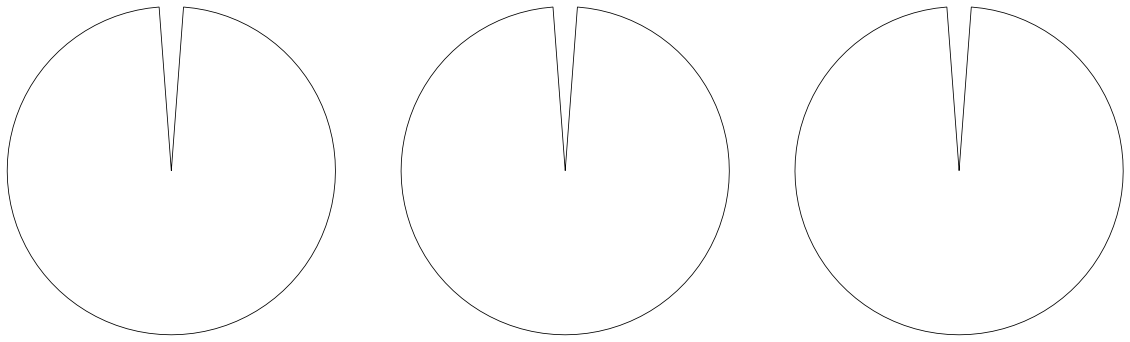

In [110]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

i = 1
gpi =  gpi2_list[i] #gpi_mod_warp #gpi_sar_warp #
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor=cfeature.COLORS['land'])

# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,9), subplot_kw={'projection': crs})

# Figure 1



sar_filtered1 = np.where(gpi, sar12_ssim_list[i], np.nan)
#img1 = ax1.imshow(sar_filtered1, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img1 = ax1.imshow(mod_ssim_not_ft_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax1.set_title(f'{date_labels[i]}: SSIM - PM without FT ')

ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)

# Figure 2


sar_filtered2 = np.where(gpi_sar_warp, sar_ssim_list[i], np.nan)
#img2 = ax2.imshow(sar_filtered2, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)#
img2 = ax2.imshow(mod_ssim_ft_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax2.set_title(f'{date_labels[i]}: SSIM - PM with FT')

ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax2, shrink=0.5)

# Figure 3

#ax2.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')

#mod_filtered = np.where(gpi, mod_ssim_list[i], np.nan)
img3 = ax3.imshow(mod_filtered, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img3 = ax3.imshow(mod_ssim_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax3.set_title(f'{date_labels[i]}: SSIM - combined PM with and without FT')
ax3.add_feature(land_50m, edgecolor='black')
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img2, ax=ax3, shrink=0.5)





plt.tight_layout()
plt.show()


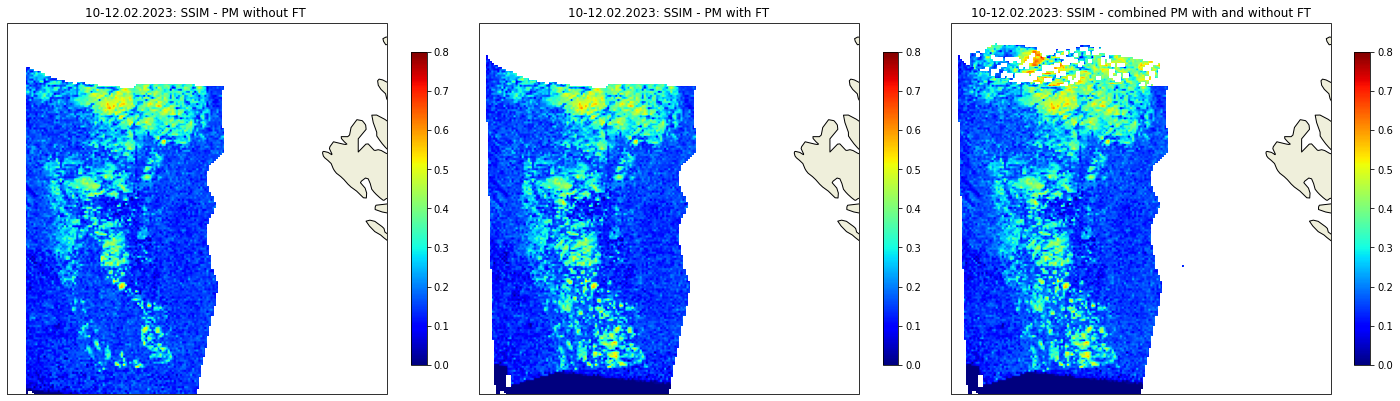

In [54]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

i = 9
gpi =  gpi2_list[i] #gpi_mod_warp #gpi_sar_warp #
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor=cfeature.COLORS['land'])

# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,9), subplot_kw={'projection': crs})

# Figure 1



sar_filtered1 = np.where(gpi, sar12_ssim_list[i], np.nan)
#img1 = ax1.imshow(sar_filtered1, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img1 = ax1.imshow(mod_ssim_not_ft_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax1.set_title(f'{date_labels[i]}: SSIM - PM without FT ')

ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)

# Figure 2


sar_filtered2 = np.where(gpi_sar_warp, sar_ssim_list[i], np.nan)
#img2 = ax2.imshow(sar_filtered2, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)#
img2 = ax2.imshow(mod_ssim_ft_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax2.set_title(f'{date_labels[i]}: SSIM - PM with FT')

ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax2, shrink=0.5)

# Figure 3

#ax2.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')

#mod_filtered = np.where(gpi, mod_ssim_list[i], np.nan)
img3 = ax3.imshow(mod_filtered, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img3 = ax3.imshow(mod_ssim_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax3.set_title(f'{date_labels[i]}: SSIM - combined PM with and without FT')
ax3.add_feature(land_50m, edgecolor='black')
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img2, ax=ax3, shrink=0.5)





plt.tight_layout()
plt.show()


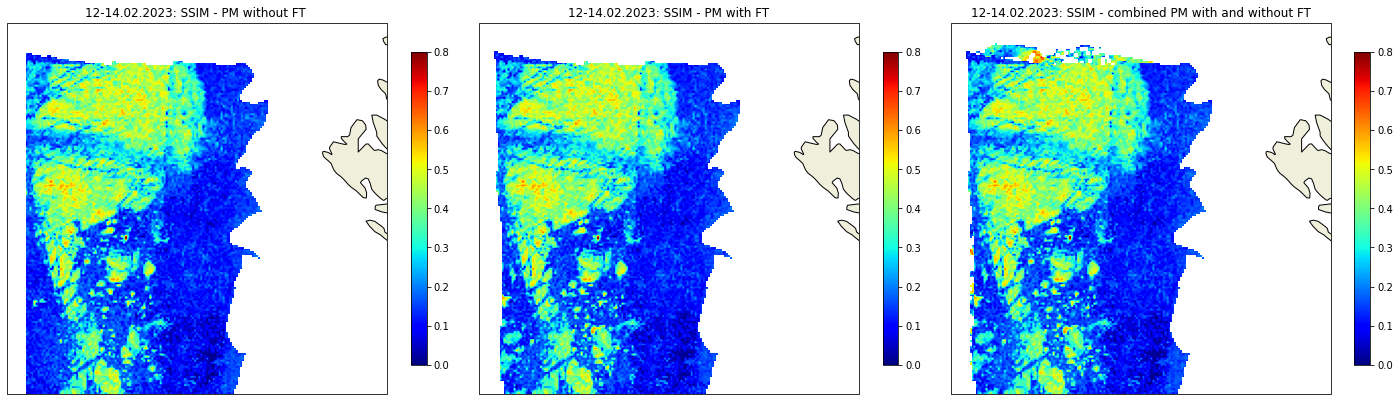

In [55]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

i = 10
gpi =  gpi2_list[i] #gpi_mod_warp #gpi_sar_warp #
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor=cfeature.COLORS['land'])

# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,9), subplot_kw={'projection': crs})

# Figure 1



sar_filtered1 = np.where(gpi, sar12_ssim_list[i], np.nan)
#img1 = ax1.imshow(sar_filtered1, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img1 = ax1.imshow(mod_ssim_not_ft_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax1.set_title(f'{date_labels[i]}: SSIM - PM without FT ')

ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)

# Figure 2


sar_filtered2 = np.where(gpi_sar_warp, sar_ssim_list[i], np.nan)
#img2 = ax2.imshow(sar_filtered2, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)#
img2 = ax2.imshow(mod_ssim_ft_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax2.set_title(f'{date_labels[i]}: SSIM - PM with FT')

ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax2, shrink=0.5)

# Figure 3

#ax2.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')

#mod_filtered = np.where(gpi, mod_ssim_list[i], np.nan)
img3 = ax3.imshow(mod_filtered, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img3 = ax3.imshow(mod_ssim_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax3.set_title(f'{date_labels[i]}: SSIM - combined PM with and without FT')
ax3.add_feature(land_50m, edgecolor='black')
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img2, ax=ax3, shrink=0.5)





plt.tight_layout()
plt.show()


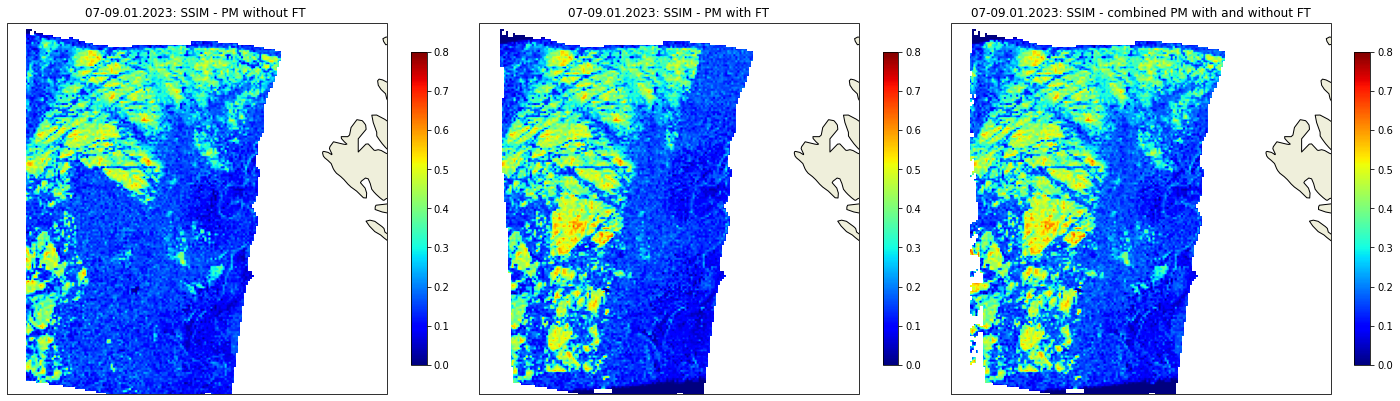

In [52]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

i = 7
gpi =  gpi2_list[i] #gpi_mod_warp #gpi_sar_warp #
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor=cfeature.COLORS['land'])

# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,9), subplot_kw={'projection': crs})

# Figure 1



sar_filtered1 = np.where(gpi, sar12_ssim_list[i], np.nan)
#img1 = ax1.imshow(sar_filtered1, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img1 = ax1.imshow(mod_ssim_not_ft_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax1.set_title(f'{date_labels[i]}: SSIM - PM without FT ')

ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax1, shrink=0.5)

# Figure 2


sar_filtered2 = np.where(gpi_sar_warp, sar_ssim_list[i], np.nan)
#img2 = ax2.imshow(sar_filtered2, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)#
img2 = ax2.imshow(mod_ssim_ft_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax2.set_title(f'{date_labels[i]}: SSIM - PM with FT')

ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img1, ax=ax2, shrink=0.5)

# Figure 3

#ax2.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')

#mod_filtered = np.where(gpi, mod_ssim_list[i], np.nan)
img3 = ax3.imshow(mod_filtered, extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.7)
img3 = ax3.imshow(mod_ssim_list[i], extent=[x.min(), x.max(), y.min(), y.max()], origin='upper', cmap='jet', alpha=1, vmin=0, vmax=0.8)
ax3.set_title(f'{date_labels[i]}: SSIM - combined PM with and without FT')
ax3.add_feature(land_50m, edgecolor='black')
ax3.set_xlim([x.min(), x.max()-79000])
ax3.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(img2, ax=ax3, shrink=0.5)





plt.tight_layout()
plt.show()


## 4. SAR and model drift comparison

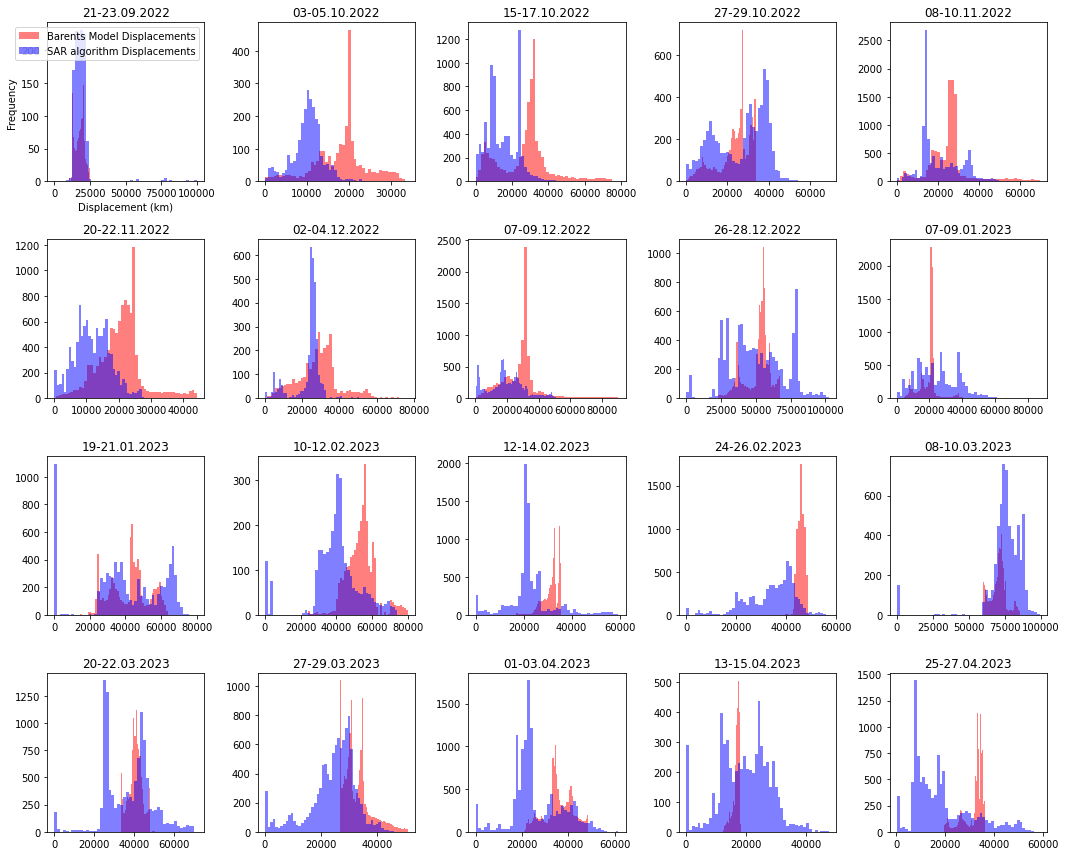

In [153]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 5, figsize=(15, 12))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Loop through all nine datasets
for i, ax in enumerate(axs):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    disp_model_b = disp_model_b[gpi2_list[i]].flatten()
    disp_alg = disp_alg[gpi2_list[i]].flatten()


    # Plot histograms
    ax.hist(disp_model_b, bins=50, color='red', alpha=0.5, label='Barents Model Displacements')
    ax.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm Displacements')

    # Set the title to the corresponding date
    ax.set_title(date_labels[i])

    # Only add labels and legend to the first subplot for clarity
    if i == 0:
        ax.set_xlabel('Displacement (km)')
        ax.set_ylabel('Frequency')
        ax.legend()

# Adjust the layout
plt.tight_layout()


# Show the plot
plt.show()
#save_plot(save_dir, "all_disp_comparison")
plt.close(fig)

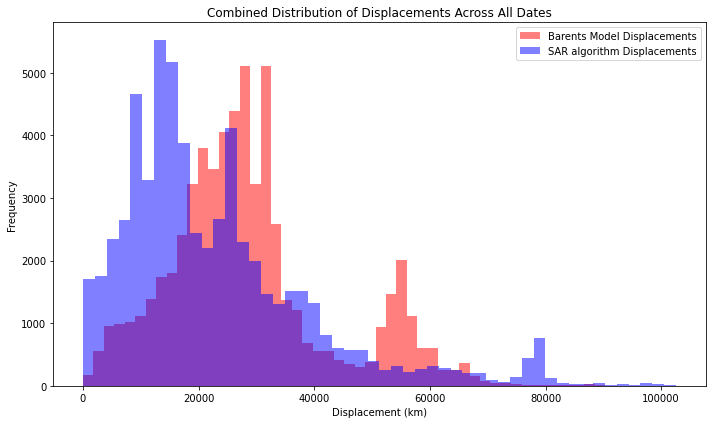

In [174]:
# Initialize a list to collect all displacements
all_disp_alg = []
all_disp_model_b = []

# Loop through all nine datasets
for i in range(9):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b = disp_model_b[gpi2_list[i]].flatten()
    disp_alg = disp_alg[gpi2_list[i]].flatten()

    # Collect the displacements
    all_disp_alg.extend(disp_alg)
    all_disp_model_b.extend(disp_model_b)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
# Plot the combined histograms
plt.hist(all_disp_model_b, bins=50, color='red', alpha=0.5, label='Barents Model Displacements')
plt.hist(all_disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm Displacements')

# Add labels and legend
plt.xlabel('Displacement (km)')
plt.ylabel('Frequency')
plt.title('Combined Distribution of Displacements Across All Dates')
plt.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()
#save_plot(save_dir, "all_disp_in_one_hist_comparison")
plt.close(fig)

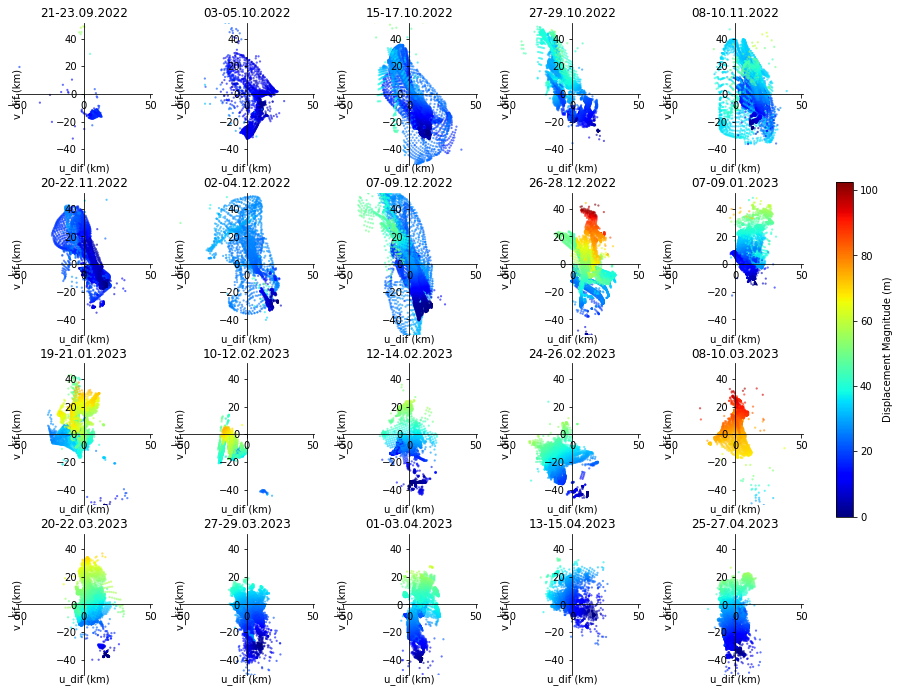

In [175]:
fig, axs = plt.subplots(4, 5, figsize=(15, 12))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Calculate global range of displacement magnitudes
global_min, global_max = float('inf'), float('-inf')
for i in range(len(u_sar_list)):
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()/1000
    global_min = min(global_min, disp_alg_masked.min())
    global_max = max(global_max, disp_alg_masked.max())
    # Generate a color array based on the magnitude of the points
    colors = disp_alg_masked

# Normalize the color range globally
norm = plt.Normalize(global_min, global_max)

# Creating a ScalarMappable object for the colorbar
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])  # You have to set_array for the ScalarMappable

# Loop through all nine datasets
for i, ax in enumerate(axs):
    # Calculate the displacement
    u_dif = u_b_list[i]/1000 - u_sar_list[i]/1000
    v_dif = v_b_list[i]/1000 - v_sar_list[i]/1000

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the absolute total displacement for colours
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()/1000
    
    # Generate a color array based on the magnitude of the points
    colors = disp_alg_masked
    
    # Create the scatter plot for the current dataset
    scatter = ax.scatter(u_dif, v_dif, c=colors, cmap='jet', norm=norm, alpha=0.6, edgecolors='none', s=5) #viridis

    

    # Move axes to go through (0,0)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    
    # Move axis labels outside
    ax.xaxis.set_label_coords(1.05, 0.01)
    ax.yaxis.set_label_coords(0.05, 1.02)

    # Hide top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    

    # Set the title to the corresponding date
    ax.set_title(date_labels[i])
           
    ax.set_xlabel('u_dif (km)')
    ax.set_ylabel('v_dif (km)')
    
    # Only add labels and legend to the first subplot for clarity
    #if i == 0:
        #ax.legend()
    
#Setting Equal Axis Limits:
max_abs_val = max([max(abs(u_dif.max()), abs(u_dif.min()), abs(v_dif.max()), abs(v_dif.min())) for i in range(len(u_sar_list))])
for ax in axs:
    ax.set_xlim([-max_abs_val, max_abs_val])
    ax.set_ylim([-max_abs_val, max_abs_val])





# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Displacement Magnitude (m)')

# Adjust the layout
#plt.tight_layout()

# Show the plot
plt.show()

# Uncomment the next line to save the plot
# save_plot(save_dir, "all_disp_comparison")

plt.close(fig)


In [89]:
import numpy as np



# Set data for p,lotting

all_u_dif = []
all_v_dif = []
all_disp_mag = []  # Store the displacement magnitudes
all_mod_disp_mag = [] 

# Loop through the datasets
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = u_b_list[i] - u_sar_list[i]
    v_dif = v_b_list[i] - v_sar_list[i]

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the magnitude of sar displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)

    # Apply the mask from gpi2_list and flatten the array
    disp_mag = disp_alg[gpi2_list[i]].flatten()
    
    # Calculate the magnitude of mod displacement
    mod_disp_mag = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    # Apply the mask from gpi2_list and flatten the array
    mod_disp_mag = mod_disp_mag[gpi2_list[i]].flatten()


    # Collect the displacements and their magnitudes
    all_u_dif.extend(u_dif)
    all_v_dif.extend(v_dif)
    all_disp_mag.extend(disp_mag)
    all_mod_disp_mag.extend(mod_disp_mag)

      
# Convert lists to numpy arrays
all_u_dif = np.array(all_u_dif)
all_v_dif = np.array(all_v_dif)
all_disp_mag = np.array(all_disp_mag)
all_mod_disp_mag = np.array(all_mod_disp_mag)

# Calculate MAE and RMSE for u_dif and v_dif
mae_u = np.mean(np.abs(all_u_dif))
mae_v = np.mean(np.abs(all_v_dif))
mae_total_speed = np.mean(np.abs(all_disp_mag-all_mod_disp_mag))

rmse_u = np.sqrt(np.mean(all_u_dif**2))
rmse_v = np.sqrt(np.mean(all_v_dif**2))
rmse_total_speed = np.sqrt(np.mean((all_disp_mag-all_mod_disp_mag)**2))


(mae_u/1000, mae_v/1000, rmse_u/1000, rmse_v/1000, mae_total_speed/1000, rmse_total_speed/1000)



(7.885239760945233,
 13.858489485403814,
 9.874042585455511,
 17.68318113568347,
 12.812595490847302,
 16.38205756768382)

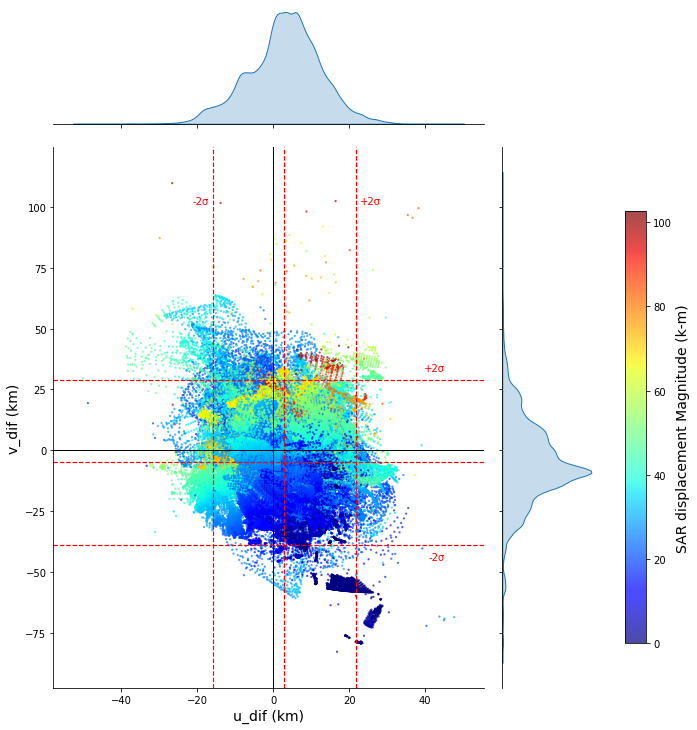

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Set data for p,lotting

all_u_dif = []
all_v_dif = []
all_disp_mag = []  # Store the displacement magnitudes

# Loop through the datasets
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = u_b_list[i]/1000 - u_sar_list[i]/1000
    v_dif = v_b_list[i]/1000 - v_sar_list[i]/1000

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the magnitude of sar displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)

    # Apply the mask from gpi2_list and flatten the array
    disp_mag = disp_alg[gpi2_list[i]].flatten() / 1000  # Converting to km

    # Collect the displacements and their magnitudes
    all_u_dif.extend(u_dif)
    all_v_dif.extend(v_dif)
    all_disp_mag.extend(disp_mag)
    
    
# Initialize a JointGrid
joint_grid = sns.JointGrid(x=all_u_dif, y=all_v_dif,  height=10, ratio=4)

# Plot a scatter plot in the center
joint_grid.plot_joint(sns.scatterplot, alpha=0.7, edgecolor='none', s=5)

# Plot KDE plots on the margins
joint_grid.plot_marginals(sns.kdeplot, fill=True) #color = "grey"

# Set the axis labels
joint_grid.set_axis_labels('u_dif (km)', 'v_dif (km)',  fontsize=14)

# Calculate means and standard deviations
mean_x, std_x = np.mean(all_u_dif), np.std(all_u_dif)
mean_y, std_y = np.mean(all_v_dif), np.std(all_v_dif)

# Add lines for means and ±2 standard deviations on the scatter plot

# For horizontal lines
label_offset_y = max(all_v_dif) * 0.025  # Adjust the offset as needed
joint_grid.ax_joint.axvline(mean_x, color='r', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.axvline(mean_x - 2*std_x, color='r', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.axvline(mean_x + 2*std_x, color='r', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.text(x=max(all_u_dif)*0.95, y=mean_y + 2*std_y + label_offset_y, s='+2σ', color='r', verticalalignment='bottom', horizontalalignment='right')
joint_grid.ax_joint.text(x=max(all_u_dif)*0.95, y=mean_y - 2*std_y - label_offset_y, s='-2σ', color='r', verticalalignment='top', horizontalalignment='right')


# For vertical lines
label_offset_x = max(all_u_dif) * 0.025  # Adjust the offset as needed
joint_grid.ax_joint.axhline(mean_y, color='r', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.axhline(mean_y - 2*std_y, color='r', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.axhline(mean_y + 2*std_y, color='r', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.text(x=mean_x + 2*std_x + label_offset_x, y=max(all_v_dif)*0.95, s='+2σ', color='r', verticalalignment='top', horizontalalignment='left')
joint_grid.ax_joint.text(x=mean_x - 2*std_x - label_offset_x, y=max(all_v_dif)*0.95, s='-2σ', color='r', verticalalignment='top', horizontalalignment='right')


# Add two vertical lines intersecting at (0, 0)
joint_grid.ax_joint.axvline(0, color='k', linestyle='-', linewidth = 1)
joint_grid.ax_joint.axhline(0, color='k', linestyle='-', linewidth = 1)


# Color each point based on the displacement magnitude
points = joint_grid.ax_joint.collections[0]  # Get the points collection
points.set_cmap('jet')  # Set the colormap, instead viridis can be used
points.set_norm(plt.Normalize(vmin=np.min(all_disp_mag), vmax=np.max(all_disp_mag)))  # Normalize with a max value of 80, instead max can be used: np.max(all_disp_mag)
points.set_array(np.array(all_disp_mag))  # Set the array of values for coloring

# Adjust layout to make space for the colorbar
plt.subplots_adjust(right=0.8)

# Add a colorbar to the right of the plot
cbar_ax = joint_grid.fig.add_axes([0.84, 0.1, 0.03, 0.6])  # Adjust these values as needed
cbar = plt.colorbar(points, cax=cbar_ax)
cbar.set_label('SAR displacement Magnitude (k-m)', fontsize=14)

# Adjust layout for better alignment
#plt.tight_layout()

# Show the plot
plt.show()


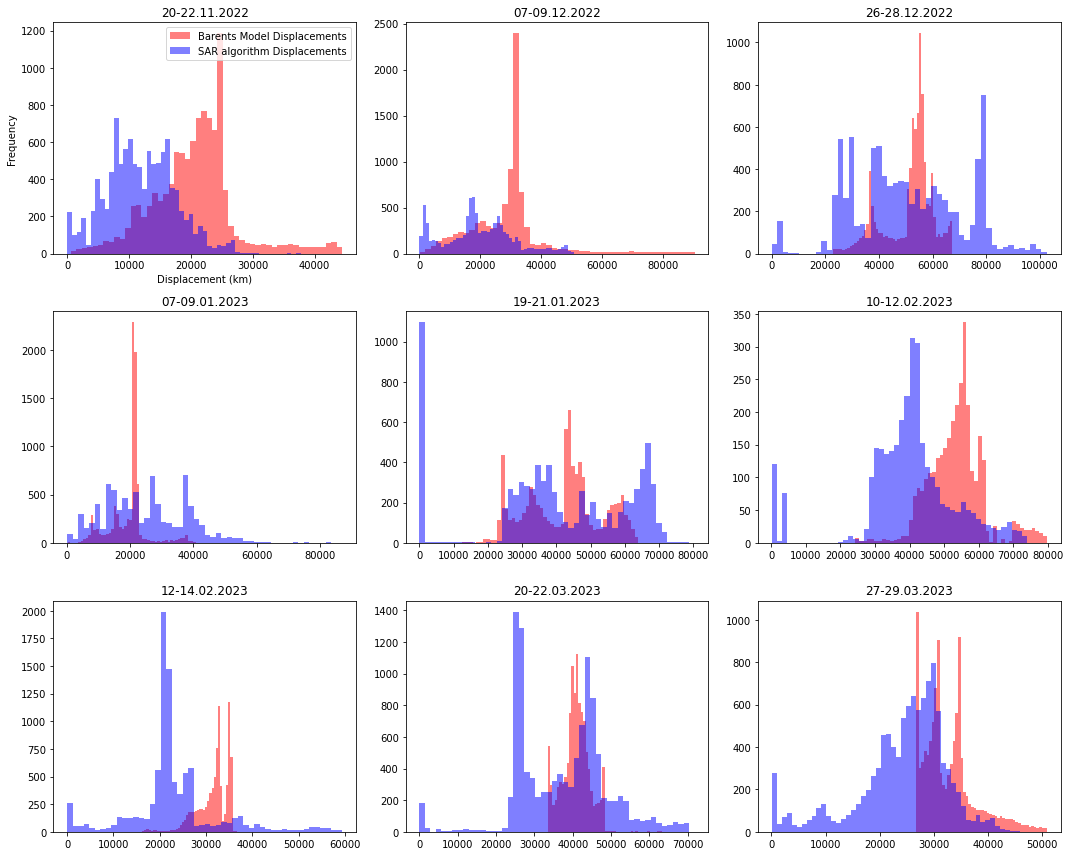

In [12]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Loop through all nine datasets
for i, ax in enumerate(axs):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    disp_model_b = disp_model_b[gpi2_list[i]].flatten()
    disp_alg = disp_alg[gpi2_list[i]].flatten()


    # Plot histograms
    ax.hist(disp_model_b, bins=50, color='red', alpha=0.5, label='Barents Model Displacements')
    ax.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm Displacements')

    # Set the title to the corresponding date
    ax.set_title(date_labels[i])

    # Only add labels and legend to the first subplot for clarity
    if i == 0:
        ax.set_xlabel('Displacement (km)')
        ax.set_ylabel('Frequency')
        ax.legend()

# Adjust the layout
plt.tight_layout()


# Show the plot
plt.show()
#save_plot(save_dir, "all_disp_comparison")
plt.close(fig)

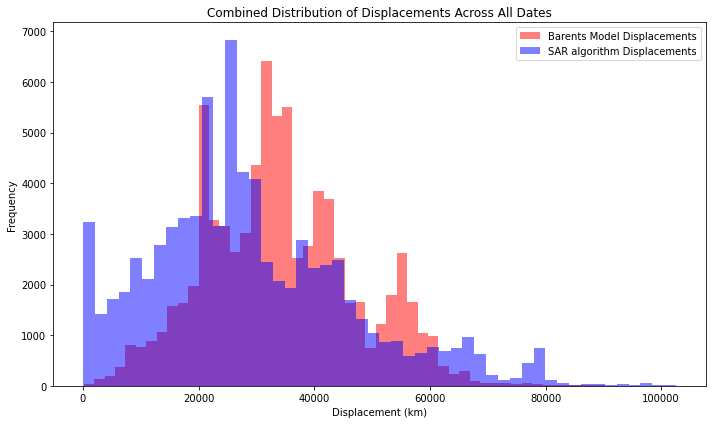

In [87]:
# Initialize a list to collect all displacements
all_disp_alg = []
all_disp_model_b = []

# Loop through all nine datasets
for i in range(9):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b = disp_model_b[gpi2_list[i]].flatten()
    disp_alg = disp_alg[gpi2_list[i]].flatten()

    # Collect the displacements
    all_disp_alg.extend(disp_alg)
    all_disp_model_b.extend(disp_model_b)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
# Plot the combined histograms
plt.hist(all_disp_model_b, bins=50, color='red', alpha=0.5, label='Barents Model Displacements')
plt.hist(all_disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm Displacements')

# Add labels and legend
plt.xlabel('Displacement (km)')
plt.ylabel('Frequency')
plt.title('Combined Distribution of Displacements Across All Dates')
plt.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()
#save_plot(save_dir, "all_disp_in_one_hist_comparison")
plt.close(fig)

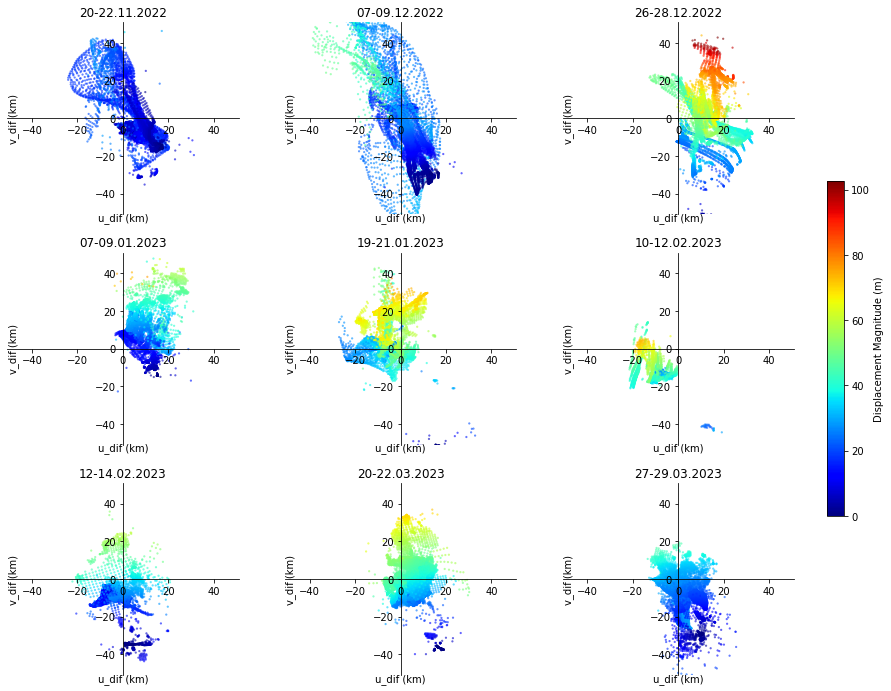

In [139]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Calculate global range of displacement magnitudes
global_min, global_max = float('inf'), float('-inf')
for i in range(len(u_sar_list)):
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()/1000
    global_min = min(global_min, disp_alg_masked.min())
    global_max = max(global_max, disp_alg_masked.max())
    # Generate a color array based on the magnitude of the points
    colors = disp_alg_masked

# Normalize the color range globally
norm = plt.Normalize(global_min, global_max)

# Creating a ScalarMappable object for the colorbar
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])  # You have to set_array for the ScalarMappable

# Loop through all nine datasets
for i, ax in enumerate(axs):
    # Calculate the displacement
    u_dif = u_b_list[i]/1000 - u_sar_list[i]/1000
    v_dif = v_b_list[i]/1000 - v_sar_list[i]/1000

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the absolute total displacement for colours
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()/1000
    
    # Generate a color array based on the magnitude of the points
    colors = disp_alg_masked
    
    # Create the scatter plot for the current dataset
    scatter = ax.scatter(u_dif, v_dif, c=colors, cmap='jet', norm=norm, alpha=0.6, edgecolors='none', s=5) #viridis

    

    # Move axes to go through (0,0)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    
    # Move axis labels outside
    ax.xaxis.set_label_coords(1.05, 0.01)
    ax.yaxis.set_label_coords(0.05, 1.02)

    # Hide top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    

    # Set the title to the corresponding date
    ax.set_title(date_labels[i])
           
    ax.set_xlabel('u_dif (km)')
    ax.set_ylabel('v_dif (km)')
    
    # Only add labels and legend to the first subplot for clarity
    #if i == 0:
        #ax.legend()
    
#Setting Equal Axis Limits:
max_abs_val = max([max(abs(u_dif.max()), abs(u_dif.min()), abs(v_dif.max()), abs(v_dif.min())) for i in range(len(u_sar_list))])
for ax in axs:
    ax.set_xlim([-max_abs_val, max_abs_val])
    ax.set_ylim([-max_abs_val, max_abs_val])





# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Displacement Magnitude (m)')

# Adjust the layout
#plt.tight_layout()

# Show the plot
plt.show()

# Uncomment the next line to save the plot
# save_plot(save_dir, "all_disp_comparison")

plt.close(fig)


In [ ]:
sns.jointplot( x="bill_length_mm", y="bill_depth_mm")

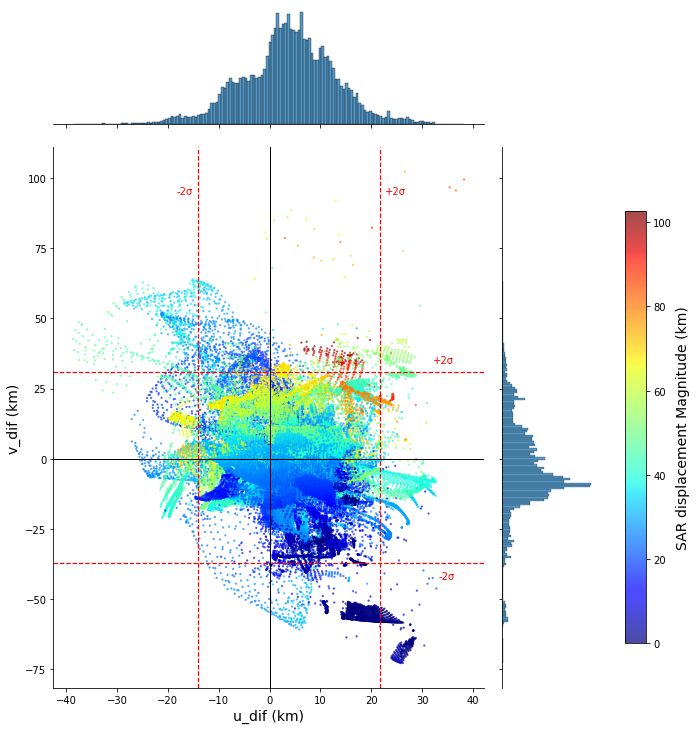

In [114]:

# Set data for p,lotting
all_u_dif = []
all_v_dif = []
all_disp_mag = []  # Store the displacement magnitudes

# Loop through the datasets
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = u_b_list[i]/1000 - u_sar_list[i]/1000
    v_dif = v_b_list[i]/1000 - v_sar_list[i]/1000

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the magnitude of sar displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)

    # Apply the mask from gpi2_list and flatten the array
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten() / 1000  # Converting to km

    # Collect the displacements and their magnitudes
    all_u_dif.extend(u_dif)
    all_v_dif.extend(v_dif)
    all_disp_mag.extend(disp_alg_masked)

# Create a scatter plot using Seaborn's jointplot
joint_plot = sns.jointplot(x=all_u_dif, y=all_v_dif, kind="scatter", alpha=0.7, edgecolor='none', s=5, height=10, ratio=4)

# Set the axis labels
joint_plot.set_axis_labels('u_dif (km)', 'v_dif (km)',fontsize=14)

# Calculate means and standard deviations
mean_x, std_x = np.mean(all_u_dif), np.std(all_u_dif)
mean_y, std_y = np.mean(all_v_dif), np.std(all_v_dif)

# Add lines for means and ±2 standard deviations on the scatter plot

# For horizontal lines
label_offset_y = max(all_v_dif) * 0.025  # Adjust the offset as needed
#joint_grid.ax_joint.axvline(mean_x, color='g', linestyle='--', linewidth = 1.2)
joint_plot.ax_joint.axvline(mean_x - 2*std_x, color='r', linestyle='--', linewidth = 1.2)
joint_plot.ax_joint.axvline(mean_x + 2*std_x, color='r', linestyle='--', linewidth = 1.2)
joint_plot.ax_joint.text(x=max(all_u_dif)*0.95, y=mean_y + 2*std_y + label_offset_y, s='+2σ', color='r', verticalalignment='bottom', horizontalalignment='right')
joint_plot.ax_joint.text(x=max(all_u_dif)*0.95, y=mean_y - 2*std_y - label_offset_y, s='-2σ', color='r', verticalalignment='top', horizontalalignment='right')


# For vertical lines
label_offset_x = max(all_u_dif) * 0.025  # Adjust the offset as needed
#joint_grid.ax_joint.axhline(mean_y, color='g', linestyle='--', linewidth = 1.2)
joint_plot.ax_joint.axhline(mean_y - 2*std_y, color='r', linestyle='--', linewidth = 1.2)
joint_plot.ax_joint.axhline(mean_y + 2*std_y, color='r', linestyle='--', linewidth = 1.2)
joint_plot.ax_joint.text(x=mean_x + 2*std_x + label_offset_x, y=max(all_v_dif)*0.95, s='+2σ', color='r', verticalalignment='top', horizontalalignment='left')
joint_plot.ax_joint.text(x=mean_x - 2*std_x - label_offset_x, y=max(all_v_dif)*0.95, s='-2σ', color='r', verticalalignment='top', horizontalalignment='right')

# Add two vertical lines intersecting at (0, 0)
joint_plot.ax_joint.axvline(0, color='k', linestyle='-', linewidth = 1)
joint_plot.ax_joint.axhline(0, color='k', linestyle='-', linewidth = 1)


# For plotting on histograms
# Add lines for means and ±2 standard deviations on x-axis histogram
#joint_plot.ax_marg_x.axvline(mean_x, color='r', linestyle='--')
#joint_plot.ax_marg_x.axvline(mean_x - 2*std_x, color='g', linestyle='--')
#joint_plot.ax_marg_x.axvline(mean_x + 2*std_x, color='g', linestyle='--')

# Add lines for means and ±2 standard deviations on y-axis histogram
#joint_plot.ax_marg_y.axhline(mean_y, color='r', linestyle='--')
#joint_plot.ax_marg_y.axhline(mean_y - 2*std_y, color='g', linestyle='--')
#joint_plot.ax_marg_y.axhline(mean_y + 2*std_y, color='g', linestyle='--')

# Color each point based on the displacement magnitude
points = joint_plot.ax_joint.collections[0]  # Get the points collection
points.set_cmap('jet')  # Set the colormap, instead viridis can be used
points.set_norm(plt.Normalize(vmin=np.min(all_disp_mag), vmax=np.max(all_disp_mag)))  # Normalize with a max value of 80, instead max can be used: np.max(all_disp_mag)
points.set_array(np.array(all_disp_mag))  # Set the array of values for coloring

# Adjust layout to make space for the colorbar
plt.subplots_adjust(right=0.8)

# Add a colorbar to the right of the plot
cbar_ax = joint_plot.fig.add_axes([0.84, 0.1, 0.03, 0.6])  # Adjust these values as needed
cbar = plt.colorbar(points, cax=cbar_ax)
cbar.set_label('SAR displacement Magnitude (km)',fontsize=14)

# Adjust layout for better alignment
#plt.tight_layout()

# Show the plot
plt.show()


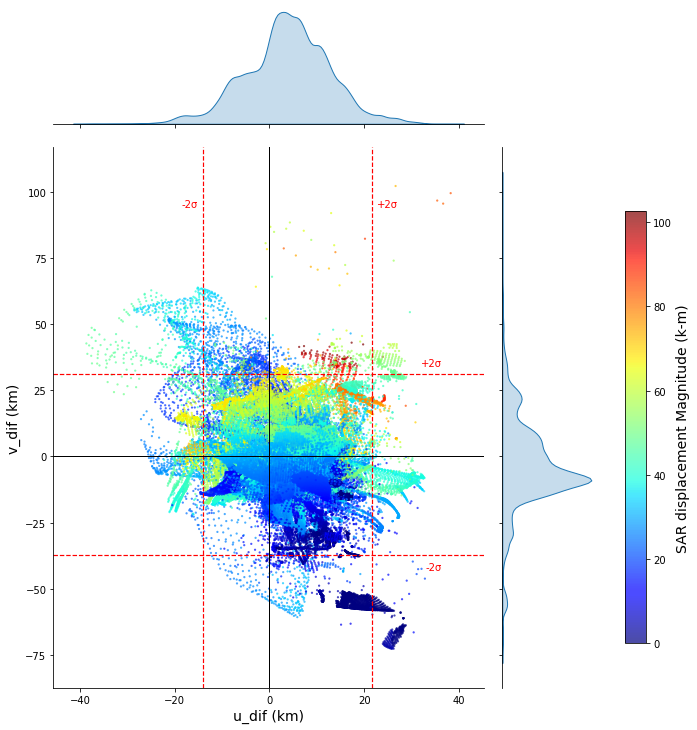

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Set data for p,lotting

all_u_dif = []
all_v_dif = []
all_disp_mag = []  # Store the displacement magnitudes

# Loop through the datasets
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = u_b_list[i]/1000 - u_sar_list[i]/1000
    v_dif = v_b_list[i]/1000 - v_sar_list[i]/1000

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the magnitude of sar displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)

    # Apply the mask from gpi2_list and flatten the array
    disp_mag = disp_alg[gpi2_list[i]].flatten() / 1000  # Converting to km

    # Collect the displacements and their magnitudes
    all_u_dif.extend(u_dif)
    all_v_dif.extend(v_dif)
    all_disp_mag.extend(disp_mag)
    
    
# Initialize a JointGrid
joint_grid = sns.JointGrid(x=all_u_dif, y=all_v_dif,  height=10, ratio=4)

# Plot a scatter plot in the center
joint_grid.plot_joint(sns.scatterplot, alpha=0.7, edgecolor='none', s=5)

# Plot KDE plots on the margins
joint_grid.plot_marginals(sns.kdeplot, fill=True) #color = "grey"

# Set the axis labels
joint_grid.set_axis_labels('u_dif (km)', 'v_dif (km)',  fontsize=14)

# Calculate means and standard deviations
mean_x, std_x = np.mean(all_u_dif), np.std(all_u_dif)
mean_y, std_y = np.mean(all_v_dif), np.std(all_v_dif)

# Add lines for means and ±2 standard deviations on the scatter plot

# For horizontal lines
label_offset_y = max(all_v_dif) * 0.025  # Adjust the offset as needed
#joint_grid.ax_joint.axvline(mean_x, color='g', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.axvline(mean_x - 2*std_x, color='r', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.axvline(mean_x + 2*std_x, color='r', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.text(x=max(all_u_dif)*0.95, y=mean_y + 2*std_y + label_offset_y, s='+2σ', color='r', verticalalignment='bottom', horizontalalignment='right')
joint_grid.ax_joint.text(x=max(all_u_dif)*0.95, y=mean_y - 2*std_y - label_offset_y, s='-2σ', color='r', verticalalignment='top', horizontalalignment='right')


# For vertical lines
label_offset_x = max(all_u_dif) * 0.025  # Adjust the offset as needed
#joint_grid.ax_joint.axhline(mean_y, color='g', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.axhline(mean_y - 2*std_y, color='r', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.axhline(mean_y + 2*std_y, color='r', linestyle='--', linewidth = 1.2)
joint_grid.ax_joint.text(x=mean_x + 2*std_x + label_offset_x, y=max(all_v_dif)*0.95, s='+2σ', color='r', verticalalignment='top', horizontalalignment='left')
joint_grid.ax_joint.text(x=mean_x - 2*std_x - label_offset_x, y=max(all_v_dif)*0.95, s='-2σ', color='r', verticalalignment='top', horizontalalignment='right')


# Add two vertical lines intersecting at (0, 0)
joint_grid.ax_joint.axvline(0, color='k', linestyle='-', linewidth = 1)
joint_grid.ax_joint.axhline(0, color='k', linestyle='-', linewidth = 1)


# Color each point based on the displacement magnitude
points = joint_grid.ax_joint.collections[0]  # Get the points collection
points.set_cmap('jet')  # Set the colormap, instead viridis can be used
points.set_norm(plt.Normalize(vmin=np.min(all_disp_mag), vmax=np.max(all_disp_mag)))  # Normalize with a max value of 80, instead max can be used: np.max(all_disp_mag)
points.set_array(np.array(all_disp_mag))  # Set the array of values for coloring

# Adjust layout to make space for the colorbar
plt.subplots_adjust(right=0.8)

# Add a colorbar to the right of the plot
cbar_ax = joint_grid.fig.add_axes([0.84, 0.1, 0.03, 0.6])  # Adjust these values as needed
cbar = plt.colorbar(points, cax=cbar_ax)
cbar.set_label('SAR displacement Magnitude (k-m)', fontsize=14)

# Adjust layout for better alignment
#plt.tight_layout()

# Show the plot
plt.show()


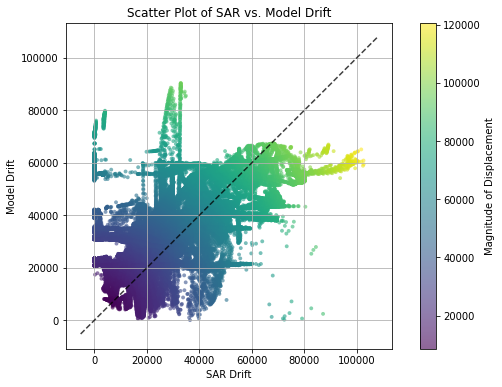

In [133]:
# Initialize empty lists to collect all displacements
all_disp_alg = []
all_disp_model_b = []

# Assuming u_sar_list, v_sar_list, u_b_list, v_b_list, and gpi2_list are defined
# Loop through all datasets and collect displacements
for i in range(9):
    # Your existing code for calculating displacements goes here
    
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b = disp_model_b[gpi2_list[i]].flatten()
    disp_alg = disp_alg[gpi2_list[i]].flatten()

    # Collect the displacements
    all_disp_alg.extend(disp_alg)
    all_disp_model_b.extend(disp_model_b)

# Convert the lists to NumPy arrays
all_disp_alg = np.array(all_disp_alg)
all_disp_model_b = np.array(all_disp_model_b)

# Now create the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color array based on the magnitude of the points
colors = np.sqrt(all_disp_alg**2 + all_disp_model_b**2)
scatter = ax.scatter(all_disp_alg, all_disp_model_b, c=colors, cmap='viridis', alpha=0.6, edgecolors='none', s=15)

# Plot a 45-degree line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k', alpha=0.75, zorder=2, linestyle="--")  # 45 degree line
ax.set_aspect('equal', 'box')  # ensure aspect ratio is equal

# Add labels and title
ax.set_xlabel('SAR Drift')
ax.set_ylabel('Model Drift')
ax.set_title('Scatter Plot of SAR vs. Model Drift')

# Create a colorbar legend
cbar = plt.colorbar(scatter)
cbar.set_label('Magnitude of Displacement')

# Show grid
plt.grid(True)

# Display the plot
plt.show()
#save_plot(save_dir, "Disp_comparison_scatter_plot")
plt.close(fig)

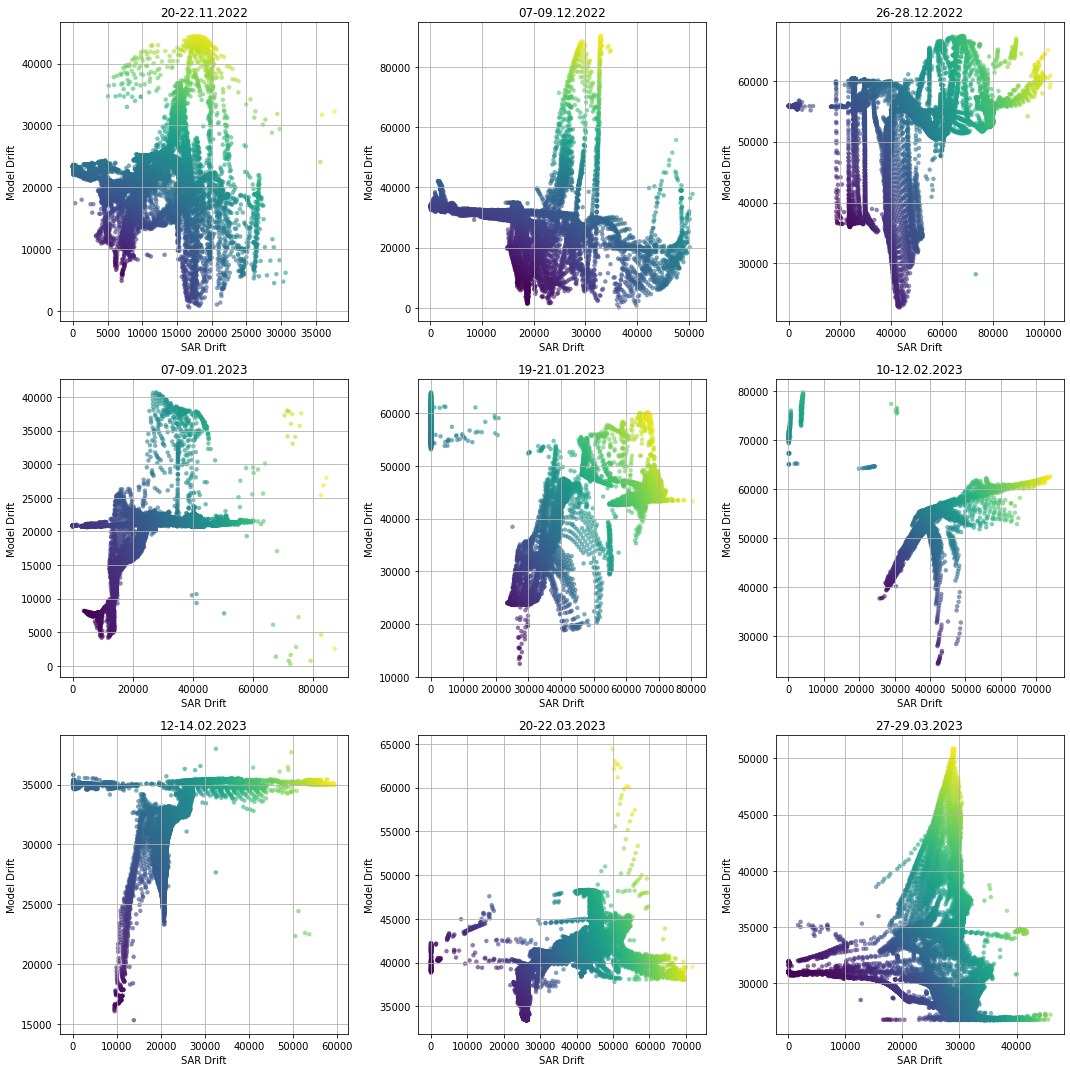

In [76]:
# Initialize a figure with 9 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted for 9 subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through all datasets and create scatter plots for each
for i in range(9):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b_masked = disp_model_b[gpi2_list[i]].flatten()
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()

    # Generate a color array based on the magnitude of the points
    colors = np.sqrt(disp_alg_masked**2 + disp_model_b_masked**2)
    
    # Create the scatter plot for the current dataset
    scatter = axes[i].scatter(disp_alg_masked, disp_model_b_masked, c=colors, cmap='viridis', alpha=0.6, edgecolors='none', s=20)
    

    # Set labels and titles for each subplot
    axes[i].set_xlabel('SAR Drift')
    axes[i].set_ylabel('Model Drift')
    axes[i].set_title(f'{date_labels[i]}')
    axes[i].grid(True)

# Adjust layout to prevent overlap
fig.tight_layout()

#save_plot(save_dir, "disp_comparison_9")
# Show the plot
plt.show()

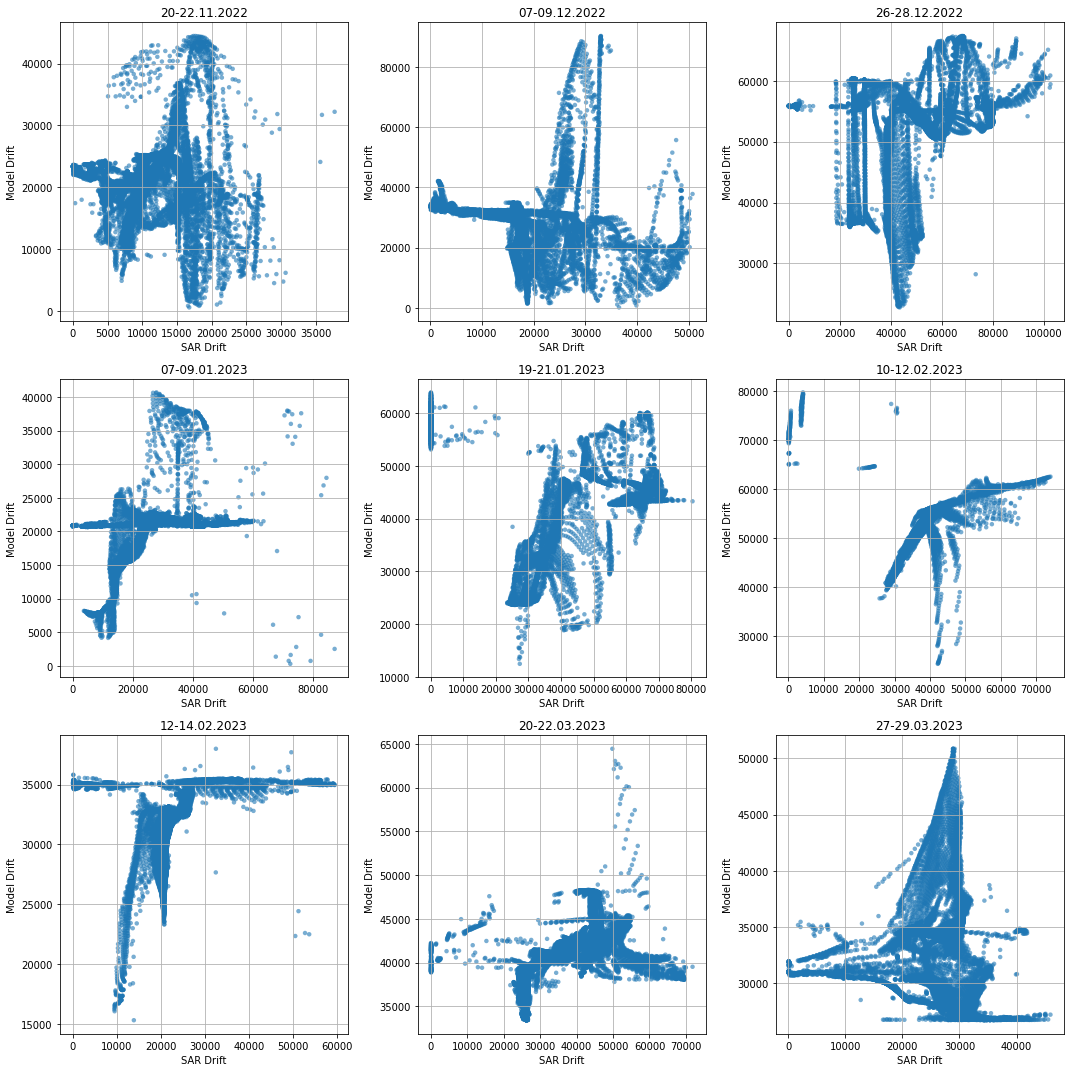

In [75]:
# Re-initialize the figure with 9 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted for 9 subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through all datasets and create scatter plots for each
for i in range(9):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b_masked = disp_model_b[gpi2_list[i]].flatten()
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()

    # Create the scatter plot for the current dataset without a line of best fit
    axes[i].scatter(disp_alg_masked, disp_model_b_masked, alpha=0.6, edgecolors='none', s=20)

    # Set labels and titles for each subplot
    axes[i].set_xlabel('SAR Drift')
    axes[i].set_ylabel('Model Drift')
    axes[i].set_title(f'{date_labels[i]}')
    axes[i].grid(True)

# Adjust layout to prevent overlap
fig.tight_layout()
#save_plot(save_dir, "disp_comparison_9")
# Show the plot
plt.show()
